In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
from shapely.geometry import Polygon, Point
from descartes.patch import PolygonPatch
from shapely.geometry import MultiLineString
BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

In [3]:
#os.listdir("../problems")
data_dir = "../problems"
problems = [x for x in os.listdir(data_dir)]
problems = {
    int(x.split(".")[0].split("_")[1]): os.path.join(data_dir, x) for x in problems
}
#problems
def read_problem(path):
    with open(path) as f:
        data = json.load(f)
    return data


In [4]:
def set_limits(ax, x0, xN, y0, yN):
    ax.set_xlim(x0, xN)
    #ax.set_xticks(range(x0, xN+1))
    ax.set_ylim(y0, yN)
    #ax.set_yticks(range(y0, yN+1))
    ax.set_aspect("equal")
    

def plot_lines(ax, ob, color=GRAY, zorder=1, linewidth=3, alpha=1):
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, color=color, linewidth=linewidth, solid_capstyle='round', zorder=zorder, alpha=alpha)

def plot_coords(ax, ob, color=GRAY, zorder=1, alpha=1):
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, 'o', color=color, zorder=zorder, alpha=alpha)

def plot_bounds(ax, ob, zorder=1, alpha=1):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color=BLACK, zorder=zorder, alpha=alpha)

    
def draw_problem(i):
    plt.close('all')
    data = read_problem(problems[i])
    hole = Polygon(data['hole'])
    xx = [x for (x, y) in data['hole']]
    yy = [y for (x, y) in data['hole']]
    SIZE=(3*3,3)
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=SIZE, dpi=90)
    ax = axes[0]
    patch = PolygonPatch(hole, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=2)
    ax.add_patch(patch)

    set_limits(ax, np.min(xx)-1, np.max(xx)+3,  np.max(yy)+3, np.min(yy)-1)
    #ax.invert_yaxis()
    # figure
    ax = axes[1]
    figure = data['figure']
    vertices = figure['vertices']
    edges = figure['edges']
    figure_shape = MultiLineString([(vertices[s], vertices[e]) for s, e in edges])
    plot_coords(ax, figure_shape)
    # plot_bounds(ax, figure_shape)
    plot_lines(ax, figure_shape)
    xx = [x for (x, y) in vertices]
    yy = [y for (x, y) in vertices]
    set_limits(ax, np.min(xx)-1, np.max(xx)+3,  np.max(yy)+3, np.min(yy)-1)
    # both
    ax=axes[2]
    patch = PolygonPatch(hole, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=2)

    ax.add_patch(patch)
    plot_coords(ax, figure_shape)
    # plot_bounds(ax, figure_shape)
    plot_lines(ax, figure_shape)
    xx = [x for (x, y) in vertices] + [x for (x, y) in data['hole']]
    yy = [y for (x, y) in vertices] + [y for (x, y) in data['hole']]

    set_limits(ax, np.min(xx)-1, np.max(xx)+3,  np.max(yy)+3, np.min(yy)-1)
    plt.show()


In [5]:
from ipywidgets import interact

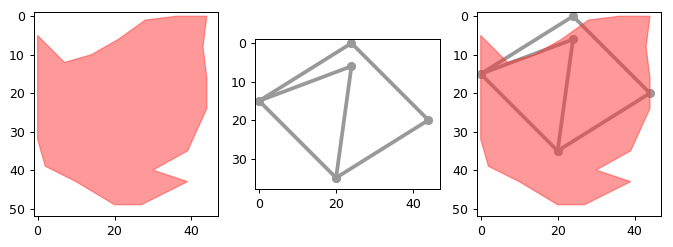

In [159]:
draw_problem(30)

In [7]:
def draw_pair(hole_poly, figure_shape, filename=None, label="", new_vert=[]):
    fig = plt.figure(figsize=(3, 3))
    ax = plt.gca()
    patch = PolygonPatch(hole_poly, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plot_coords(ax, figure_shape)
    # plot_bounds(ax, figure_shape)
    plot_lines(ax, figure_shape)
    if len(new_vert) == 0:
        [x.coords[:]for x in figure_shape.geoms]
        new_vert = sorted(set([ c for x in figure_shape.geoms for c in x.coords[:]]))
    # print(repr(new_vert), flush=True)
    #dist = get_distance(hole_poly, figure_shape)
    dist = get_distance(data, new_vert)
    plt.title(f"Current distance: {dist} - {label}")
    # hole_poly.bounds
    x0, y0, x1, y1 = hole_poly.union(figure_shape).bounds

    set_limits(ax, x0 - 1, x1+3,  y1 + 3, y0 - 1)
    
    if filename is not None:
        fig.savefig(filename)
    plt.show()

In [42]:
def get_dist(p, q):
    return (p[0]-q[0])**2+(p[1]-q[1])**2

def get_distance_old(hole_poly, figure_shape):
    figure_vertices = sorted(set([y for x in figure_shape.geoms for y in x.coords]))
    min_distances = [
        np.min([get_dist(p, q) for q in figure_vertices])
        for p in hole_poly.exterior.coords
    ]
    return np.sum(min_distances)

def get_distance(data, new_vertices):
    min_distances = [
        np.min([get_dist(p, q) for q in new_vertices])
        for p in data['hole']
    ]
    return np.sum(min_distances)

In [312]:
for k in range(16, 60):
    data = read_problem(problems[k])
    figure = data['figure']
    hvertices = data['hole']
    vertices = figure['vertices']
    n = len(hvertices)
    edges = [(i, j) for i, j in zip(np.arange(n), (np.arange(n)+1)%n)]
    hedges = [(hvertices[i], hvertices[j]) for i,j in edges]
    fedges = [(vertices[i], vertices[j]) for i, j in figure['edges']]
    # fvertices = len(data['figure']['vertices'])
    # if hvertices==fvertices:
    #     print(i)
    distances = []
    for i, p in enumerate(hedges):
        for j, q in enumerate(fedges):
            dp = get_dist(*p)
            dq = get_dist(*q)
            if dp==dq:
                distances.append((dp, i, j))
    if len(distances) > 0:
        print(k, distances, len(distances), len(hvertices), len(vertices))
        problem_id = k
        break

16 [(533, 0, 2), (557, 1, 4), (557, 2, 4), (533, 3, 2)] 4 5 5


In [247]:
data = read_problem(problems[16])

In [248]:
from igraph import *
g = Graph(data['figure']['edges'])

In [249]:
# layout = g.layout_kamada_kawai()

In [250]:
# list(layout)

In [251]:
distances

[(533, 0, 2), (557, 1, 4), (557, 2, 4), (533, 3, 2)]

In [252]:
figure

{'edges': [[0, 1], [0, 2], [1, 3], [2, 4], [3, 4]],
 'vertices': [[8, 6], [26, 22], [21, 25], [19, 0], [0, 14]]}

In [253]:
positions_lists = []
for d, i, j in distances:
    # print(i, j, edges[i], figure['edges'][j])
    if len(positions_lists) < 1:
        vi, vj = edges[i]
        hi, hj = figure['edges'][j]
        positions_lists.append([(hi, vi), (hj, vj)])
        positions_lists.append([(hi, vj), (hj, vi)])
        continue
    new_pos = []
    vi, vj = edges[i]
    hi, hj = figure['edges'][j]
    for poslist in positions_lists:
        if (hi, vi) not in poslist:
            new_pos.append(poslist+[(hi, vi)])
        if (hj, vj) not in poslist:
            new_pos.append(poslist+[(hj, vj)])
        if (hi, vj) not in poslist:
            new_pos.append(poslist+[(hi, vj)])
        if (hi, vj) not in poslist:
            new_pos.append(poslist+[(hi, vj)])
    positions_lists = new_pos

In [254]:
mapping = dict(positions_lists[0])
{k: data['hole'][v] for k, v in mapping.items()}

{1: [22, 38], 3: [36, 19], 4: [36, 19]}

In [255]:
data['hole']

[[0, 7], [22, 0], [36, 19], [22, 38], [0, 31]]

In [256]:
mapping

{1: 3, 3: 2, 4: 2}

In [257]:
set(positions_lists[0])

{(1, 0), (1, 3), (3, 1), (3, 2), (4, 2)}

In [584]:
problem_id=15 # 22
data = read_problem(problems[problem_id])

In [585]:
targets = data['hole']
sources = data['figure']['vertices']
epsilon = data['epsilon']
orig_edges = data['figure']['edges']

In [650]:
from collections import defaultdict

def vect(u, v):
    return [y - x for x, y in zip(u, v)]

def mult(u, m):
    return [m*x for x in u]
def len2(u):
    return np.sum([x**2 for x in u])

def length(u):
    return np.sqrt(len2(u))

def sums(*b):
    # print(b, "b", len(b))
    if len(b) == 1:
        #print("return b")
        return b[0]
    return [np.sum(x) for x in zip(*b)]

def means(*b):
    return [np.mean(x) for x in zip(*b)]
    

def compute_forces(current_pos, orig_edges, targets, sources, epsilon, magnets=dict()):
    forces = defaultdict(list)
    # center force
#     if len(magnets) == 0:
#         z = means(current_pos)
#         for i, x in enumerate(current_pos):
#             forces[i].append(mult(vect(z, x), 0.1))
        
    for src, tgts in magnets.items():
        u = current_pos[src]
        for t in tgts:
            v = targets[t]
            d = vect(u, v)
            #print(src, tgts, length(d))
            if length(d) < 10:# and len(tgts)==1: # was 1 condition
                m = 1.
            elif length(d) < 1:
                m = 0
            else:
                m = 0.5 # was:0.5
            forces[src].append(mult(d, m))
    for s, e in orig_edges:
        a, b = current_pos[s], current_pos[e]
        u, v = sources[s], sources[e]
        dn = len2(vect(a, b))
        do = len2(vect(u, v))
        if dn/do-1 > epsilon/1000000:
            direction = 1*(np.sqrt(dn)-np.sqrt(do))
        elif dn/do-1 < - epsilon/1000000:
            direction = -1*(np.sqrt(do)-np.sqrt(dn))
        else:
            direction = 0.01
        if direction > 0:
            forces[s].append(mult(vect(a, b), direction))
            forces[e].append(mult(vect(b, a), direction))
    for k in range(len(sources)):
        forces[k].append((0, 0))
    return forces
    
    pass
def modify_pos(pos, delta, forces,verbose=True):
    force = sums(*forces)
    if verbose:
        print(forces)
        print(pos, force)
    
    #print(pos, delta, force)
    #print([(p,f) for p, f in zip(pos, force)])
    return [ (p + f*delta) for p, f in zip(pos, force)]

[[10.0, 12.0], [0.2, -0.2], [0.2, 0.2], (0, 0)]
[0, 20] [10.399999999999999, 12.0]
[[7.5, 10.0], [-0.2, 0.2], [0.2, 0.2], (0, 0)]
[20, 0] [7.5, 10.399999999999999]
[[-10.0, -8.0], [-0.2, -0.2], [0.2, -0.2], [0.29, 0.05], (0, 0)]
[20, 40] [-9.71, -8.349999999999998]
[[-12.5, -10.0], [-0.2, -0.2], [-0.2, 0.2], [0.09, 0.25], (0, 0)]
[40, 20] [-12.809999999999999, -9.75]
[[-7.0, -12.5], [-14.5, -0.5], [-0.29, -0.05], [-0.09, -0.25], (0, 0)]
[49, 45] [-21.88, -13.3]


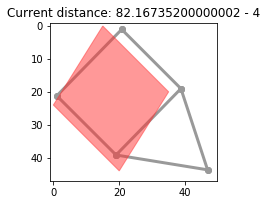

[[9.48, 11.4], (0, 0)]
[1.0399999999999998, 21.2] [9.48, 11.4]
[[7.125, 9.48], (0, 0)]
[20.75, 1.0399999999999998] [7.125, 9.48]
[[-9.5145, -7.5825], (0, 0)]
[19.029, 39.165] [-9.5145, -7.5825]
[[-11.8595, -9.5125], (0, 0)]
[38.719, 19.025] [-11.8595, -9.5125]
[[-5.905999999999999, -11.835], [-13.405999999999999, 0.16499999999999915], (0, 0)]
[46.812, 43.67] [-19.311999999999998, -11.670000000000002]


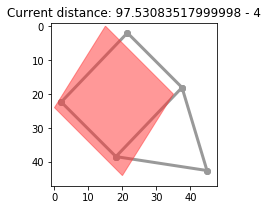

[[9.006, 10.83], (0, 0)]
[1.988, 22.34] [9.006, 10.83]
[[6.768750000000001, 9.006], (0, 0)]
[21.4625, 1.988] [6.768750000000001, 9.006]
[[-9.038775, -7.203375000000001], (0, 0)]
[18.07755, 38.40675] [-9.038775, -7.203375000000001]
[[-11.266525000000001, -9.036874999999998], (0, 0)]
[37.53305, 18.073749999999997] [-11.266525000000001, -9.036874999999998]
[[-4.9404, -11.2515], [-12.4404, 0.7484999999999999], (0, 0)]
[44.8808, 42.503] [-17.3808, -10.503]


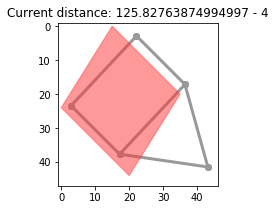

[[8.5557, 10.2885], (0, 0)]
[2.8886000000000003, 23.423] [8.5557, 10.2885]
[[6.430312500000001, 8.5557], (0, 0)]
[22.139374999999998, 2.8886000000000003] [6.430312500000001, 8.5557]
[[-8.58683625, -6.8432062500000015], (0, 0)]
[17.1736725, 37.6864125] [-8.58683625, -6.8432062500000015]
[[-10.703198750000002, -8.585031249999998], (0, 0)]
[36.406397500000004, 17.170062499999997] [-10.703198750000002, -8.585031249999998]
[[-4.0713599999999985, -10.72635], [-11.571359999999999, 1.27365], (0, 0)]
[43.14272, 41.4527] [-15.642719999999997, -9.4527]


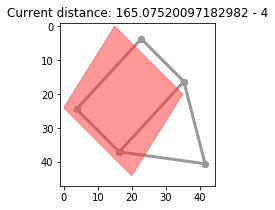

[[8.127915, 9.774075000000002], (0, 0)]
[3.7441700000000004, 24.451849999999997] [8.127915, 9.774075000000002]
[[6.108796875000001, 8.127915], (0, 0)]
[22.782406249999998, 3.7441700000000004] [6.108796875000001, 8.127915]
[[-8.157494437499999, -6.5010459375000025], (0, 0)]
[16.314988874999997, 37.002091875000005] [-8.157494437499999, -6.5010459375000025]
[[-10.1680388125, -8.155779687499999], (0, 0)]
[35.336077625, 16.311559374999998] [-10.1680388125, -8.155779687499999]
[[-3.2892239999999973, -10.253715], [-10.789223999999997, 1.7462850000000003], (0, 0)]
[41.578447999999995, 40.50743] [-14.078447999999995, -8.50743]


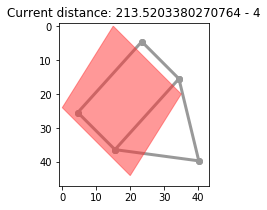

[[7.72151925, 9.28537125], (0, 0)]
[4.556961500000001, 25.4292575] [7.72151925, 9.28537125]
[[5.803357031250002, 7.72151925], (0, 0)]
[23.393285937499996, 4.556961500000001] [5.803357031250002, 7.72151925]
[[-7.749619715624998, -6.175993640625002], (0, 0)]
[15.499239431249997, 36.351987281250004] [-7.749619715624998, -6.175993640625002]
[[-9.659636871875001, -7.747990703124999], (0, 0)]
[34.31927374375, 15.495981406249998] [-9.659636871875001, -7.747990703124999]
[[-2.5853015999999975, -9.828343499999999], [-10.085301599999998, 2.171656500000001], (0, 0)]
[40.170603199999995, 39.656687] [-12.670603199999995, -7.656686999999998]


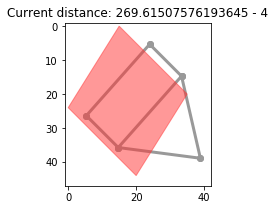

[[7.3354432874999995, 8.821102687500002], (0, 0)]
[5.329113425000001, 26.357794624999997] [7.3354432874999995, 8.821102687500002]
[[5.513189179687501, 7.3354432874999995], (0, 0)]
[23.973621640624998, 5.329113425000001] [5.513189179687501, 7.3354432874999995]
[[-7.362138729843749, -5.867193958593752], (0, 0)]
[14.724277459687498, 35.734387917187505] [-7.362138729843749, -5.867193958593752]
[[-9.176655028281253, -7.360591167968749], (0, 0)]
[33.353310056562506, 14.721182335937497] [-9.176655028281253, -7.360591167968749]
[[-1.9517714399999981, -9.44550915], [-9.451771439999998, 2.5544908500000005], (0, 0)]
[38.903542879999996, 38.8910183] [-11.403542879999996, -6.891018299999999]


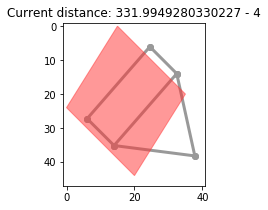

[[6.968671123125, 8.380047553125001], (0, 0)]
[6.062657753750001, 27.239904893749998] [6.968671123125, 8.380047553125001]
[[5.237529720703126, 6.968671123125], (0, 0)]
[24.524940558593748, 6.062657753750001] [5.237529720703126, 6.968671123125]
[[-6.994031793351561, -5.573834260664064], (0, 0)]
[13.988063586703122, 35.14766852132813] [-6.994031793351561, -5.573834260664064]
[[-8.717822276867189, -6.992561609570311], (0, 0)]
[32.43564455373438, 13.985123219140622] [-8.717822276867189, -6.992561609570311]
[[-1.3815942959999994, -9.100958235], [-8.881594296, 2.8990417649999998], (0, 0)]
[37.763188592, 38.20191647] [-10.263188591999999, -6.2019164700000005]


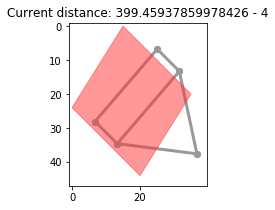

[[6.62023756696875, 7.961045175468751], (0, 0)]
[6.759524866062501, 28.077909649062498] [6.62023756696875, 7.961045175468751]
[[4.97565323466797, 6.62023756696875], (0, 0)]
[25.04869353066406, 6.759524866062501] [4.97565323466797, 6.62023756696875]
[[-6.644330203683983, -5.29514254763086], (0, 0)]
[13.288660407367965, 34.59028509526172] [-6.644330203683983, -5.29514254763086]
[[-8.28193116302383, -6.6429335290917955], (0, 0)]
[31.56386232604766, 13.285867058183591] [-8.28193116302383, -6.6429335290917955]
[[-0.8684348664000012, -8.790862411500001], [-8.368434866400001, 3.209137588499999], (0, 0)]
[36.7368697328, 37.581724823] [-9.236869732800002, -5.581724823000002]


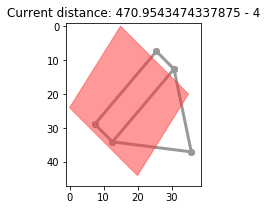

[[6.289225688620312, 7.562992916695313], (0, 0)]
[7.421548622759376, 28.874014166609374] [6.289225688620312, 7.562992916695313]
[[4.726870572934571, 6.289225688620312], (0, 0)]
[25.54625885413086, 7.421548622759376] [4.726870572934571, 6.289225688620312]
[[-6.312113693499784, -5.030385420249317], (0, 0)]
[12.624227386999568, 34.060770840498634] [-6.312113693499784, -5.030385420249317]
[[-7.8678346048726375, -6.3107868526372055], (0, 0)]
[30.735669209745275, 12.621573705274411] [-7.8678346048726375, -6.3107868526372055]
[[-0.4065913797600018, -8.51177617035], [-7.906591379760002, 3.48822382965], (0, 0)]
[35.813182759520004, 37.0235523407] [-8.313182759520004, -5.0235523407]


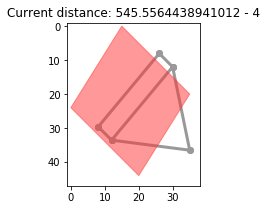

[[5.974764404189297, 7.184843270860547], (0, 0)]
[8.050471191621407, 29.630313458278906] [5.974764404189297, 7.184843270860547]
[[4.490527044287843, 5.974764404189297], (0, 0)]
[26.018945911424314, 8.050471191621407] [4.490527044287843, 5.974764404189297]
[[-5.996508008824795, -4.778866149236851], (0, 0)]
[11.99301601764959, 33.5577322984737] [-5.996508008824795, -4.778866149236851]
[[-7.4744428746290055, -5.9952475100053455], (0, 0)]
[29.94888574925801, 11.990495020010691] [-7.4744428746290055, -5.9952475100053455]
[[0.009067758215998367, -8.260598553314999], [-7.490932241784002, 3.739401446685001], (0, 0)]
[34.981864483568, 36.52119710663] [-7.481864483568003, -4.521197106629998]


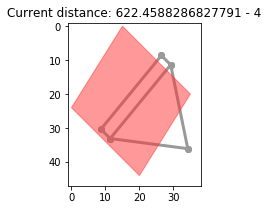

[[5.676026183979832, 6.825601107317519], (0, 0)]
[8.647947632040337, 30.34879778536496] [5.676026183979832, 6.825601107317519]
[[4.266000692073451, 5.676026183979832], (0, 0)]
[26.467998615853098, 8.647947632040337] [4.266000692073451, 5.676026183979832]
[[-5.696682608383555, -4.5399228417750095], (0, 0)]
[11.39336521676711, 33.07984568355002] [-5.696682608383555, -4.5399228417750095]
[[-7.100720730897555, -5.695485134505078], (0, 0)]
[29.20144146179511, 11.390970269010156] [-7.100720730897555, -5.695485134505078]
[[0.3831609823943971, -8.0345386979835], [-7.116839017605603, 3.9654613020165], (0, 0)]
[34.233678035211206, 36.069077395967] [-6.733678035211206, -4.069077395967]


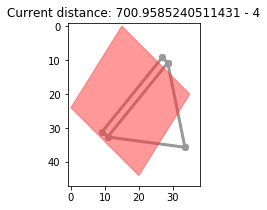

[[5.39222487478084, 6.4843210519516425], (0, 0)]
[9.21555025043832, 31.031357896096715] [5.39222487478084, 6.4843210519516425]
[[4.052700657469778, 5.39222487478084], (0, 0)]
[26.894598685060444, 9.21555025043832] [4.052700657469778, 5.39222487478084]
[[-5.411848477964377, -4.312926699686258], (0, 0)]
[10.823696955928755, 32.62585339937252] [-5.411848477964377, -4.312926699686258]
[[-6.745684694352677, -5.410710877779824], (0, 0)]
[28.491369388705355, 10.821421755559648] [-6.745684694352677, -5.410710877779824]
[[0.7198448841549592, -7.831084828185151], [-6.780155115845041, 4.168915171814849], (0, 0)]
[33.56031023169008, 35.6621696563703] [-6.060310231690082, -3.6621696563703026]


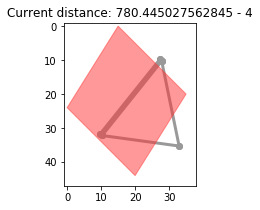

[[5.122613631041799, 6.160104999354061], (0, 0)]
[9.754772737916403, 31.679790001291877] [5.122613631041799, 6.160104999354061]
[[3.8500656245962883, 5.122613631041799], (0, 0)]
[27.299868750807423, 9.754772737916403] [3.8500656245962883, 5.122613631041799]
[[-5.141256054066159, -4.097280364701945], (0, 0)]
[10.282512108132318, 32.19456072940389] [-5.141256054066159, -4.097280364701945]
[[-6.408400459635043, -5.1401753338908325], (0, 0)]
[27.816800919270086, 10.280350667781665] [-6.408400459635043, -5.1401753338908325]
[[1.022860395739464, -7.6479763453666365], [-6.477139604260536, 4.3520236546333635], (0, 0)]
[32.95427920852107, 35.29595269073327] [-5.454279208521072, -3.295952690733273]


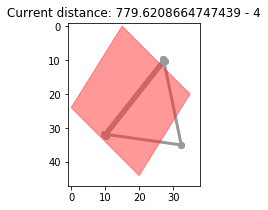

[[4.866482949489709, 5.852099749386358], (0, 0)]
[10.267034101020583, 32.29580050122728] [4.866482949489709, 5.852099749386358]
[[3.6575623433664735, 4.866482949489709], (0, 0)]
[27.684875313267053, 10.267034101020583] [3.6575623433664735, 4.866482949489709]
[[-4.884193251362851, -3.892416346466847], (0, 0)]
[9.768386502725702, 31.784832692933694] [-4.884193251362851, -3.892416346466847]
[[-6.087980436653291, -4.883166567196291], (0, 0)]
[27.175960873306582, 9.766333134392582] [-6.087980436653291, -4.883166567196291]
[[1.2955743561655169, -7.483178710829971], [-6.204425643834483, 4.516821289170029], (0, 0)]
[32.408851287668966, 34.96635742165994] [-4.908851287668966, -2.966357421659943]


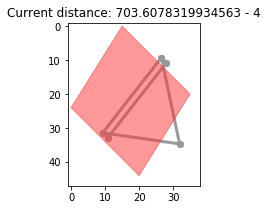

[[4.623158802015223, 5.5594947619170405], (0, 0)]
[10.753682395969554, 32.88101047616592] [4.623158802015223, 5.5594947619170405]
[[3.47468422619815, 4.623158802015223], (0, 0)]
[28.0506315476037, 10.753682395969554] [3.47468422619815, 4.623158802015223]
[[-4.639983588794709, -3.697795529143505], (0, 0)]
[9.279967177589418, 31.39559105828701] [-4.639983588794709, -3.697795529143505]
[[-5.7835814148206275, -4.639008238836476], (0, 0)]
[26.567162829641255, 9.278016477672953] [-5.7835814148206275, -4.639008238836476]
[[1.5410169205489659, -7.334860839746973], [-5.958983079451034, 4.665139160253027], (0, 0)]
[31.91796615890207, 34.66972167949395] [-4.417966158902068, -2.6697216794939465]


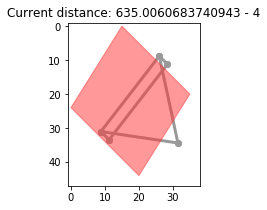

[[4.392000861914462, 5.281520023821187], (0, 0)]
[11.215998276171076, 33.436959952357626] [4.392000861914462, 5.281520023821187]
[[3.300950014888242, 4.392000861914462], (0, 0)]
[28.398099970223516, 11.215998276171076] [3.300950014888242, 4.392000861914462]
[[-4.407984409354974, -3.512905752686329], (0, 0)]
[8.815968818709948, 31.02581150537266] [-4.407984409354974, -3.512905752686329]
[[-5.494402344079596, -4.407057826894652], (0, 0)]
[25.988804688159192, 8.814115653789305] [-5.494402344079596, -4.407057826894652]
[[1.76191522849407, -7.2013747557722745], [-5.73808477150593, 4.7986252442277255], (0, 0)]
[31.47616954301186, 34.40274951154455] [-3.97616954301186, -2.402749511544549]


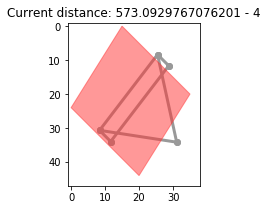

[[4.172400818818739, 5.0174440226301265], (0, 0)]
[11.655198362362523, 33.96511195473975] [4.172400818818739, 5.0174440226301265]
[[3.1359025141438295, 4.172400818818739], (0, 0)]
[28.72819497171234, 11.655198362362523] [3.1359025141438295, 4.172400818818739]
[[-4.187585188887225, -3.3372604650520135], (0, 0)]
[8.37517037777445, 30.674520930104027] [-4.187585188887225, -3.3372604650520135]
[[-5.219682226875616, -4.18670493554992], (0, 0)]
[25.43936445375123, 8.37340987109984] [-5.219682226875616, -4.18670493554992]
[[1.9607237056446625, -7.081237280195047], [-5.5392762943553375, 4.918762719804953], (0, 0)]
[31.078552588710675, 34.162474560390095] [-3.578552588710675, -2.162474560390095]


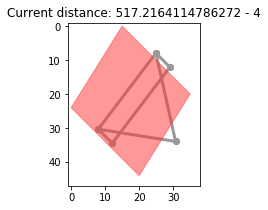

[[3.963780777877802, 4.766571821498619], (0, 0)]
[12.072438444244396, 34.46685635700276] [3.963780777877802, 4.766571821498619]
[[5.958214776873277, 7.927561555755604], (0, 0)]
[29.041785223126723, 12.072438444244396] [5.958214776873277, 7.927561555755604]
[[-3.978205929442864, -3.1703974417994125], (0, 0)]
[7.956411858885728, 30.340794883598825] [-3.978205929442864, -3.1703974417994125]
[[-4.958698115531835, -3.977369688772424], [0.3529549945397901, 1.5807943190524625], (0, 0)]
[24.91739623106367, 7.954739377544848] [-4.605743120992044, -2.3965753697199617]
[[2.1396513350801953, -6.973113552175544], [-5.360348664919805, 5.026886447824456], [-0.3529549945397901, -1.5807943190524625], (0, 0)]
[30.72069732983961, 33.94622710435109] [-3.5736523243793994, -3.527021423403551]


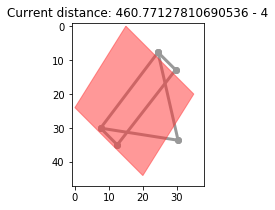

[[3.765591738983912, 4.528243230423687], (0, 0)]
[12.468816522032176, 34.943513539152626] [3.765591738983912, 4.528243230423687]
[[5.36239329918595, 7.134805400180044], (0, 0)]
[29.63760670081405, 12.865194599819956] [5.36239329918595, 7.134805400180044]
[[-7.558591265941441, -6.023755139418885], (0, 0)]
[7.558591265941441, 30.023755139418885] [-7.558591265941441, -6.023755139418885]
[[-4.728410959482233, -3.857540920286426], (0, 0)]
[24.456821918964465, 7.715081840572852] [-4.728410959482233, -3.857540920286426]
[[2.3183339512991648, -6.796762481005366], [-5.181666048700835, 5.203237518994634], (0, 0)]
[30.36333209740167, 33.59352496201073] [-2.8633320974016705, -1.5935249620107328]


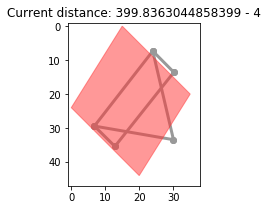

[[3.5773121520347164, 4.301831068902501], (0, 0)]
[12.845375695930567, 35.396337862195] [3.5773121520347164, 4.301831068902501]
[[4.826153969267356, 6.42132486016204], (0, 0)]
[30.173846030732644, 13.57867513983796] [4.826153969267356, 6.42132486016204]
[[-6.802732139347297, -5.421379625476995], (0, 0)]
[6.802732139347297, 29.421379625476995] [-6.802732139347297, -5.421379625476995]
[[-4.491990411508121, -3.6646638742721045], [1.436899780613423, 6.1562341107830045], (0, 0)]
[23.983980823016243, 7.329327748544209] [-3.055090630894698, 2.4915702365109]
[[2.4615005561692485, -6.71708623290483], [-5.0384994438307515, 5.28291376709517], [-1.436899780613423, -6.1562341107830045], (0, 0)]
[30.076998887661503, 33.43417246580966] [-4.013898668274926, -7.590406576592664]


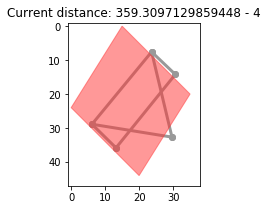

[[3.3984465444329803, 4.086739515457378], (0, 0)]
[13.20310691113404, 35.826520969085244] [3.3984465444329803, 4.086739515457378]
[[4.34353857234062, 5.779192374145836], (0, 0)]
[30.65646142765938, 14.220807625854164] [4.34353857234062, 5.779192374145836]
[[-6.122458925412567, -4.879241662929296], (0, 0)]
[6.122458925412567, 28.879241662929296] [-6.122458925412567, -4.879241662929296]
[[-4.339235879963386, -3.7892423860976496], (0, 0)]
[23.678471759926772, 7.578484772195299] [-4.339235879963386, -3.7892423860976496]
[[2.662195489582995, -6.337565904075195], [-4.837804510417005, 5.662434095924805], (0, 0)]
[29.67560902083401, 32.67513180815039] [-2.1756090208340098, -0.6751318081503896]


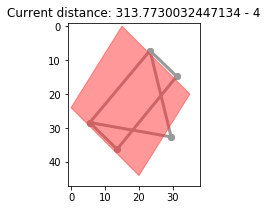

[[3.2285242172113318, 3.8824025396845094], (0, 0)]
[13.542951565577336, 36.23519492063098] [3.2285242172113318, 3.8824025396845094]
[[3.9091847151065586, 5.201273136731253], (0, 0)]
[31.09081528489344, 14.798726863268747] [3.9091847151065586, 5.201273136731253]
[[-5.51021303287131, -4.391317496636365], (0, 0)]
[5.51021303287131, 28.391317496636365] [-5.51021303287131, -4.391317496636365]
[[-4.122274085965216, -3.599780266792767], (0, 0)]
[23.244548171930433, 7.199560533585534] [-4.122274085965216, -3.599780266792767]
[[2.7709759406246963, -6.303809313667674], [-4.729024059375304, 5.696190686332326], (0, 0)]
[29.458048118750607, 32.60761862733535] [-1.9580481187506074, -0.6076186273353485]


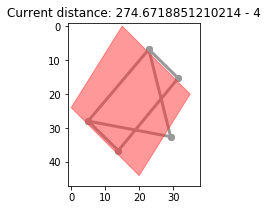

[[6.13419601270153, 7.376564825400571], (0, 0)]
[13.86580398729847, 36.62343517459943] [6.13419601270153, 7.376564825400571]
[[3.518266243595903, 4.681145823058127], (0, 0)]
[31.481733756404097, 15.318854176941873] [3.518266243595903, 4.681145823058127]
[[-4.959191729584179, -3.9521857469727273], (0, 0)]
[4.959191729584179, 27.952185746972727] [-4.959191729584179, -3.9521857469727273]
[[-3.9161603816669555, -3.4197912534531287], (0, 0)]
[22.83232076333391, 6.8395825069062575] [-3.9161603816669555, -3.4197912534531287]
[[2.8688783465622265, -6.2734283823009065], [-4.6311216534377735, 5.7265716176990935], (0, 0)]
[29.262243306875547, 32.54685676460181] [-1.762243306875547, -0.546856764601813]


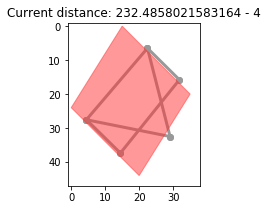

[[5.5207764114313775, 6.638908342860518], (0, 0)]
[14.479223588568622, 37.36109165713948] [5.5207764114313775, 6.638908342860518]
[[3.1664396192363142, 4.213031240752315], (0, 0)]
[31.833560380763686, 15.786968759247685] [3.1664396192363142, 4.213031240752315]
[[-4.463272556625761, -3.5569671722754563], (0, 0)]
[4.463272556625761, 27.556967172275456] [-4.463272556625761, -3.5569671722754563]
[[-7.440704725167215, -6.497603381560944], [1.7269653976618444, 6.755394441962936], (0, 0)]
[22.440704725167215, 6.497603381560944] [-5.713739327505371, 0.25779106040199196]
[[2.956990511906003, -6.246085544070816], [-4.543009488093997, 5.753914455929184], [-1.7269653976618444, -6.755394441962936], (0, 0)]
[29.086018976187994, 32.49217108814163] [-3.3129843738498383, -7.247565530104568]


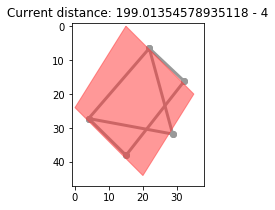

[[4.96869877028824, 5.975017508574467], (0, 0)]
[15.03130122971176, 38.02498249142553] [4.96869877028824, 5.975017508574467]
[[2.849795657312683, 3.791728116677085], (0, 0)]
[32.15020434268732, 16.208271883322915] [2.849795657312683, 3.791728116677085]
[[-4.016945300963185, -3.2012704550479114], (0, 0)]
[4.016945300963185, 27.20127045504791] [-4.016945300963185, -3.2012704550479114]
[[-6.8693307924166795, -6.523382487601143], (0, 0)]
[21.86933079241668, 6.523382487601143] [-6.8693307924166795, -6.523382487601143]
[[3.122639730598495, -5.883707267565587], [-4.377360269401505, 6.116292732434413], (0, 0)]
[28.75472053880301, 31.767414535131174] [-1.25472053880301, 0.23258546486882636]


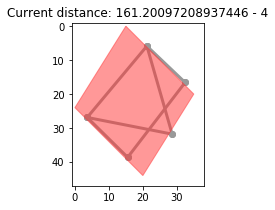

[[4.471828893259417, 5.3775157577170205], (0, 0)]
[15.528171106740583, 38.62248424228298] [4.471828893259417, 5.3775157577170205]
[[2.564816091581413, 3.412555305009377], (0, 0)]
[32.43518390841859, 16.587444694990623] [2.564816091581413, 3.412555305009377]
[[-3.6152507708668664, -2.881143409543121], (0, 0)]
[3.6152507708668664, 26.88114340954312] [-3.6152507708668664, -2.881143409543121]
[[-6.1823977131750105, -5.871044238841029], [2.9602701417703554, 10.303563976351176], (0, 0)]
[21.18239771317501, 5.871044238841029] [-3.222127571404655, 4.432519737510147]
[[3.1853757575386457, -5.895336540809028], [-4.314624242461354, 6.104663459190972], [-2.9602701417703554, -10.303563976351176], (0, 0)]
[28.62924848492271, 31.790673081618056] [-4.089518626693064, -10.094237057969233]


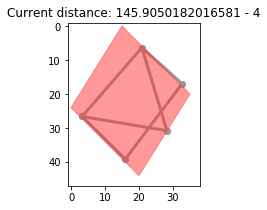

[[4.024646003933475, 4.83976418194532], (0, 0)]
[15.975353996066525, 39.16023581805468] [4.024646003933475, 4.83976418194532]
[[2.3083344824232697, 3.0712997745084394], (0, 0)]
[32.69166551757673, 16.92870022549156] [2.3083344824232697, 3.0712997745084394]
[[-3.2537256937801797, -2.593029068588809], (0, 0)]
[3.2537256937801797, 26.59302906858881] [-3.2537256937801797, -2.593029068588809]
[[-5.860184956034544, -6.314296212592044], (0, 0)]
[20.860184956034544, 6.314296212592044] [-5.860184956034544, -6.314296212592044]
[[3.389851688873298, -5.390624687910567], [-4.110148311126702, 6.609375312089433], (0, 0)]
[28.220296622253404, 30.781249375821133] [-0.7202966222534037, 1.2187506241788668]


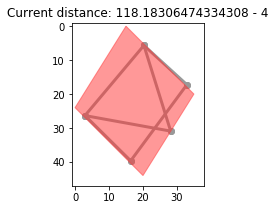

[[3.6221814035401287, 4.35578776375079], (0, 0)]
[16.37781859645987, 39.64421223624921] [3.6221814035401287, 4.35578776375079]
[[2.0775010341809406, 2.764169797057594], (0, 0)]
[32.92249896581906, 17.235830202942406] [2.0775010341809406, 2.764169797057594]
[[-2.928353124402162, -2.3337261617299276], (0, 0)]
[2.928353124402162, 26.333726161729928] [-2.928353124402162, -2.3337261617299276]
[[-5.27416646043109, -5.682866591332839], (0, 0)]
[20.27416646043109, 5.682866591332839] [-5.27416646043109, -5.682866591332839]
[[3.425866519985968, -5.451562219119509], [-4.074133480014032, 6.548437780880491], (0, 0)]
[28.148266960028064, 30.90312443823902] [-0.6482669600280637, 1.0968755617609816]


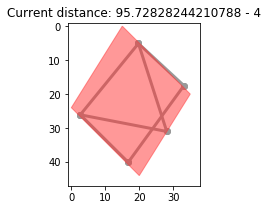

[[3.2599632631861155, 3.920208987375709], (0, 0)]
[16.740036736813884, 40.07979101262429] [3.2599632631861155, 3.920208987375709]
[[1.869750930762848, 2.487752817351833], (0, 0)]
[33.13024906923715, 17.512247182648167] [1.869750930762848, 2.487752817351833]
[[-2.635517811961946, -2.100353545556935], (0, 0)]
[2.635517811961946, 26.100353545556935] [-2.635517811961946, -2.100353545556935]
[[-4.746749814387982, -5.114579932199556], [5.304656256298999, 16.479107574624237], (0, 0)]
[19.746749814387982, 5.114579932199556] [0.5579064419110171, 11.364527642424681]
[[3.458279867987372, -5.506405997207558], [-4.041720132012628, 6.493594002792442], [-5.304656256298999, -16.479107574624237], (0, 0)]
[28.083440264025256, 31.012811994415117] [-5.888096520324256, -15.491919569039354]


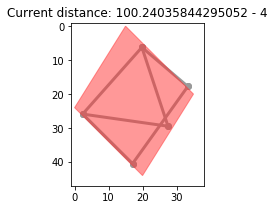

[[2.9339669368675025, 3.5281880886381387], (0, 0)]
[17.066033063132497, 40.47181191136186] [2.9339669368675025, 3.5281880886381387]
[[1.6827758376865631, 2.238977535616648], (0, 0)]
[33.31722416231344, 17.761022464383352] [1.6827758376865631, 2.238977535616648]
[[-2.3719660307657513, -1.890318191001242], (0, 0)]
[2.3719660307657513, 25.890318191001242] [-2.3719660307657513, -1.890318191001242]
[[-4.8025404585790845, -6.251032696442024], (0, 0)]
[19.802540458579085, 6.251032696442024] [-4.8025404585790845, -6.251032696442024]
[[3.752684694003584, -4.73181001875559], [-3.747315305996416, 7.26818998124441], (0, 0)]
[27.494630611992832, 29.46362003751118] [0.005369388007167686, 2.5363799624888195]


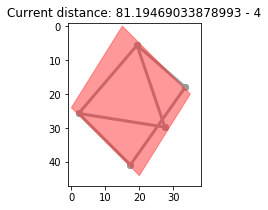

[[2.640570243180754, 3.1753692797743227], (0, 0)]
[17.359429756819246, 40.82463072022568] [2.640570243180754, 3.1753692797743227]
[[1.5144982539179068, 2.0150797820549826], (0, 0)]
[33.48550174608209, 17.984920217945017] [1.5144982539179068, 2.0150797820549826]
[[-2.134769427689176, -1.7012863719011193], (0, 0)]
[2.134769427689176, 25.70128637190112] [-2.134769427689176, -1.7012863719011193]
[[-4.322286412721176, -5.625929426797822], (0, 0)]
[19.322286412721176, 5.625929426797822] [-4.322286412721176, -5.625929426797822]
[[3.752416224603225, -4.85862901688003], [-3.747583775396775, 7.14137098311997], (0, 0)]
[27.49516755079355, 29.71725803376006] [0.004832449206450207, 2.2827419662399393]


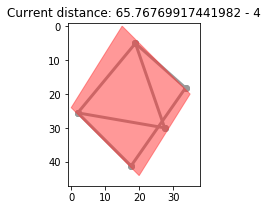

[[2.37651321886268, 2.857832351796887], (0, 0)]
[17.62348678113732, 41.14216764820311] [2.37651321886268, 2.857832351796887]
[[1.3630484285261133, 1.8135718038494844], (0, 0)]
[33.63695157147389, 18.186428196150516] [1.3630484285261133, 1.8135718038494844]
[[-1.9212924849202584, -1.5311577347110088], (0, 0)]
[1.9212924849202584, 25.53115773471101] [-1.9212924849202584, -1.5311577347110088]
[[-3.890057771449058, -5.0633364841180395], (0, 0)]
[18.890057771449058, 5.0633364841180395] [-3.890057771449058, -5.0633364841180395]
[[3.7521746021429028, -4.972766115192027], [-3.7478253978570972, 7.027233884807973], (0, 0)]
[27.495650795714194, 29.945532230384053] [0.004349204285805541, 2.054467769615947]


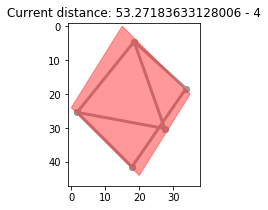

[[2.1388618969764117, 2.572049116617201], (0, 0)]
[17.86113810302359, 41.4279508833828] [2.1388618969764117, 2.572049116617201]
[[1.2267435856735034, 1.6322146234645345], (0, 0)]
[33.7732564143265, 18.367785376535466] [1.2267435856735034, 1.6322146234645345]
[[-1.7291632364282326, -1.3780419612399086], (0, 0)]
[1.7291632364282326, 25.37804196123991] [-1.7291632364282326, -1.3780419612399086]
[[-3.5010519943041523, -4.5570028357062355], [5.018901690359758, 14.28050791616287], (0, 0)]
[18.501051994304152, 4.5570028357062355] [1.517849696055606, 9.723505080456635]
[[3.751957141928612, -5.075489503672824], [-3.748042858071388, 6.924510496327176], [-5.018901690359758, -14.28050791616287], (0, 0)]
[27.496085716142776, 30.150979007345647] [-5.014987406502534, -12.431486923508517]


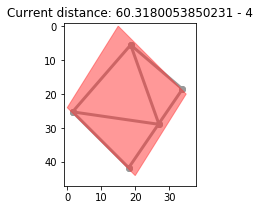

[[1.9249757072787688, 2.3148442049554774], (0, 0)]
[18.07502429272123, 41.68515579504452] [1.9249757072787688, 2.3148442049554774]
[[1.1040692271061516, 1.4689931611180818], (0, 0)]
[33.89593077289385, 18.53100683888192] [1.1040692271061516, 1.4689931611180818]
[[-1.5562469127854093, -1.2402377651159178], (0, 0)]
[1.5562469127854093, 25.240237765115918] [-1.5562469127854093, -1.2402377651159178]
[[-3.6528369639097136, -5.529353343751899], (0, 0)]
[18.652836963909714, 5.529353343751899] [-3.6528369639097136, -5.529353343751899]
[[4.002706512253738, -4.4539151574973985], [-3.497293487746262, 7.5460848425026015], (0, 0)]
[26.994586975492524, 28.907830314994797] [0.5054130245074759, 3.092169685005203]


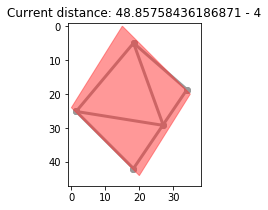

[[1.732478136550892, 2.0833597844599296], (0, 0)]
[18.267521863449108, 41.91664021554007] [1.732478136550892, 2.0833597844599296]
[[0.993662304395535, 1.3220938450062718], (0, 0)]
[34.006337695604465, 18.677906154993728] [0.993662304395535, 1.3220938450062718]
[[-1.4006222215068682, -1.1162139886043256], (0, 0)]
[1.4006222215068682, 25.116213988604326] [-1.4006222215068682, -1.1162139886043256]
[[-3.287553267518742, -4.97641800937671], (0, 0)]
[18.287553267518742, 4.97641800937671] [-3.287553267518742, -4.97641800937671]
[[3.977435861028365, -4.608523641747659], [-3.522564138971635, 7.391476358252341], (0, 0)]
[27.04512827794327, 29.21704728349532] [0.45487172205672977, 2.7829527165046812]


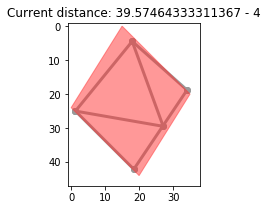

[[1.5592303228958038, 1.8750238060139353], (0, 0)]
[18.440769677104196, 42.124976193986065] [1.5592303228958038, 1.8750238060139353]
[[0.8942960739559851, 1.1898844605056453], (0, 0)]
[34.105703926044015, 18.810115539494355] [0.8942960739559851, 1.1898844605056453]
[[-1.2605599993561813, -1.0045925897438934], (0, 0)]
[1.2605599993561813, 25.004592589743893] [-1.2605599993561813, -1.0045925897438934]
[[-2.9587979407668676, -4.478776208439039], [0.552470267075323, 1.5134894096025182], (0, 0)]
[17.958797940766868, 4.478776208439039] [-2.4063276736915444, -2.9652867988365212]
[[3.954692274925529, -4.747671277572893], [-3.545307725074471, 7.252328722427107], [-0.552470267075323, -1.5134894096025182], (0, 0)]
[27.090615450148942, 29.495342555145786] [-0.14308571722426477, 0.9911680352516956]


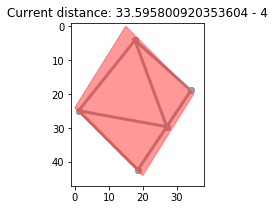

[[1.4033072906062216, 1.687521425412541], (0, 0)]
[18.59669270939378, 42.31247857458746] [1.4033072906062216, 1.687521425412541]
[[0.8048664665603837, 1.07089601445508], (0, 0)]
[34.195133533439616, 18.92910398554492] [0.8048664665603837, 1.07089601445508]
[[-1.1345039994205632, -0.9041333307695041], (0, 0)]
[1.1345039994205632, 24.904133330769504] [-1.1345039994205632, -0.9041333307695041]
[[-2.718165173397715, -4.182247528555387], [4.771469145367469, 12.957015237093534], (0, 0)]
[17.718165173397715, 4.182247528555387] [2.053303971969754, 8.774767708538146]
[[3.961846560786743, -4.797229679335478], [-3.538153439213257, 7.202770320664522], [-4.771469145367469, -12.957015237093534], (0, 0)]
[27.076306878426514, 29.594459358670957] [-4.347776023793983, -10.55147459576449]


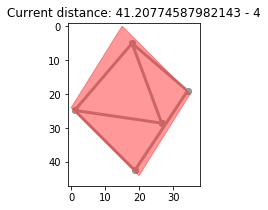

[[1.2629765615455995, 1.5187692828712898], (0, 0)]
[18.7370234384544, 42.48123071712871] [1.2629765615455995, 1.5187692828712898]
[[0.7243798199043425, 0.9638064130095714], (0, 0)]
[34.27562018009566, 19.03619358699043] [0.7243798199043425, 0.9638064130095714]
[[-1.0210535994785068, -0.8137199976925551], (0, 0)]
[1.0210535994785068, 24.813719997692555] [-1.0210535994785068, -0.8137199976925551]
[[-2.923495570594689, -5.059724299409202], (0, 0)]
[17.92349557059469, 5.059724299409202] [-2.923495570594689, -5.059724299409202]
[[4.179235361976442, -4.2696559495472535], [-3.320764638023558, 7.7303440504527465], (0, 0)]
[26.641529276047116, 28.539311899094507] [0.8584707239528839, 3.460688100905493]


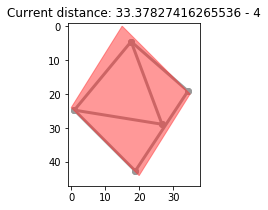

[[1.1366789053910402, 1.3668923545841594], (0, 0)]
[18.86332109460896, 42.63310764541584] [1.1366789053910402, 1.3668923545841594]
[[0.6519418379139097, 0.8674257717086142], (0, 0)]
[34.34805816208609, 19.132574228291386] [0.6519418379139097, 0.8674257717086142]
[[-0.9189482395306561, -0.7323479979232985], (0, 0)]
[0.9189482395306561, 24.7323479979233] [-0.9189482395306561, -0.7323479979232985]
[[-2.6311460135352185, -4.553751869468282], (0, 0)]
[17.63114601353522, 4.553751869468282] [-2.6311460135352185, -4.553751869468282]
[[4.136311825778797, -4.4426903545925285], [-3.3636881742212026, 7.5573096454074715], (0, 0)]
[26.727376348442405, 28.885380709185057] [0.7726236515575948, 3.114619290814943]


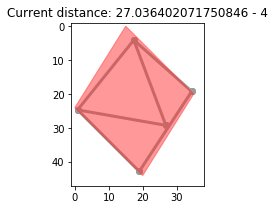

[[1.0230110148519351, 1.230203119125747], (0, 0)]
[18.976988985148065, 42.76979688087425] [1.0230110148519351, 1.230203119125747]
[[0.5867476541225187, 0.780683194537751], (0, 0)]
[34.41325234587748, 19.21931680546225] [0.5867476541225187, 0.780683194537751]
[[-0.8270534155775905, -0.6591131981309672], (0, 0)]
[0.8270534155775905, 24.659113198130967] [-0.8270534155775905, -0.6591131981309672]
[[-2.368031412181697, -4.0983766825214545], [2.2948835071136666, 6.103682577428818], (0, 0)]
[17.368031412181697, 4.0983766825214545] [-0.07314790506803037, 2.005305894907363]
[[4.097680643200917, -4.598421319133276], [-3.402319356799083, 7.401578680866724], [-2.2948835071136666, -6.103682577428818], (0, 0)]
[26.804638713598166, 29.196842638266553] [-1.5995222207118327, -3.3005252156953704]


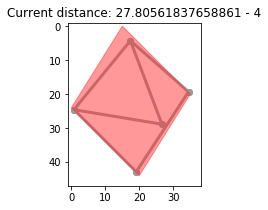

[[0.9207099133667427, 1.1071828072131709], (0, 0)]
[19.079290086633257, 42.89281719278683] [0.9207099133667427, 1.1071828072131709]
[[0.5280728887102697, 0.7026148750839774], (0, 0)]
[34.47192711128973, 19.297385124916023] [0.5280728887102697, 0.7026148750839774]
[[-0.7443480740198314, -0.5932018783178705], (0, 0)]
[0.7443480740198314, 24.59320187831787] [-0.7443480740198314, -0.5932018783178705]
[[-2.360716621674893, -4.29890727201219], (0, 0)]
[17.360716621674893, 4.29890727201219] [-2.360716621674893, -4.29890727201219]
[(0, 0)]
[26.644686491526983, 28.866790116697015] (0, 0)


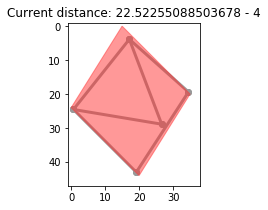

[[0.8286389220300698, 0.9964645264918559], (0, 0)]
[19.17136107796993, 43.003535473508144] [0.8286389220300698, 0.9964645264918559]
[[0.4752655998392399, 0.6323533875755807], (0, 0)]
[34.52473440016076, 19.36764661242442] [0.4752655998392399, 0.6323533875755807]
[[-0.6699132666178482, -0.5338816904860835], (0, 0)]
[0.6699132666178482, 24.533881690486083] [-0.6699132666178482, -0.5338816904860835]
[[-2.1246449595074033, -3.8690165448109712], [1.699734255571949, 4.46317087065818], (0, 0)]
[17.124644959507403, 3.8690165448109712] [-0.42491070393545427, 0.5941543258472088]
[[-1.699734255571949, -4.46317087065818], (0, 0)]
[26.644686491526983, 28.866790116697015] [-1.699734255571949, -4.46317087065818]


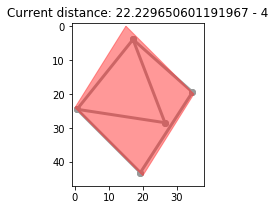

[[0.7457750298270618, 0.8968180738426668], (0, 0)]
[19.254224970172938, 43.10318192615733] [0.7457750298270618, 0.8968180738426668]
[[0.427739039855318, 0.569118048818023], (0, 0)]
[34.57226096014468, 19.430881951181977] [0.427739039855318, 0.569118048818023]
[[-0.6029219399560634, -0.4804935214374737], (0, 0)]
[0.6029219399560634, 24.480493521437474] [-0.6029219399560634, -0.4804935214374737]
[[-2.082153889113858, -3.928431977395692], (0, 0)]
[17.082153889113858, 3.928431977395692] [-2.082153889113858, -3.928431977395692]
[(0, 0)]
[26.474713065969787, 28.420473029631196] (0, 0)


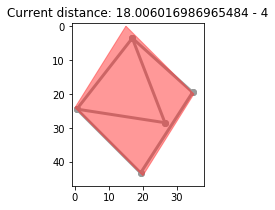

[[0.671197526844356, 0.8071362664584001], (0, 0)]
[19.328802473155644, 43.1928637335416] [0.671197526844356, 0.8071362664584001]
[[0.3849651358697841, 0.5122062439362196], (0, 0)]
[34.615034864130216, 19.48779375606378] [0.3849651358697841, 0.5122062439362196]
[[-0.542629745960457, -0.43244416929372775], (0, 0)]
[0.542629745960457, 24.432444169293728] [-0.542629745960457, -0.43244416929372775]
[[-1.8739385002024704, -3.535588779656123], [0.9795521437618685, 2.538966158131102], (0, 0)]
[16.87393850020247, 3.535588779656123] [-0.8943863564406019, -0.9966226215250211]
[[-0.9795521437618685, -2.538966158131102], (0, 0)]
[26.474713065969787, 28.420473029631196] [-0.9795521437618685, -2.538966158131102]


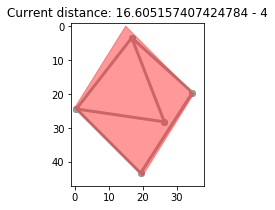

[[0.6040777741599186, 0.7264226398125615], (0, 0)]
[19.39592222584008, 43.27357736018744] [0.6040777741599186, 0.7264226398125615]
[[0.3464686222828064, 0.46098561954259765], (0, 0)]
[34.653531377717194, 19.539014380457402] [0.3464686222828064, 0.46098561954259765]
[[-0.4883667713644113, -0.38919975236435533], (0, 0)]
[0.4883667713644113, 24.389199752364355] [-0.4883667713644113, -0.38919975236435533]
[[-1.7844998645584091, -3.4359265175036207], (0, 0)]
[16.78449986455841, 3.4359265175036207] [-1.7844998645584091, -3.4359265175036207]
[(0, 0)]
[26.3767578515936, 28.166576413818085] (0, 0)


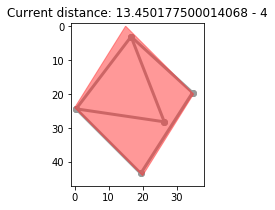

[[0.543669996743926, 0.6537803758313032], (0, 0)]
[19.456330003256074, 43.3462196241687] [0.543669996743926, 0.6537803758313032]
[[0.3118217600545279, 0.4148870575883379], (0, 0)]
[34.68817823994547, 19.585112942411662] [0.3118217600545279, 0.4148870575883379]
[[-0.4395300942279702, -0.3502797771279198], (0, 0)]
[0.4395300942279702, 24.35027977712792] [-0.4395300942279702, -0.3502797771279198]
[[-1.6060498781025672, -3.0923338657532584], [3.3221722391788124, 8.525580002761469], (0, 0)]
[16.606049878102567, 3.0923338657532584] [1.7161223610762453, 5.433246137008211]
[[-3.3221722391788124, -8.525580002761469], (0, 0)]
[26.3767578515936, 28.166576413818085] [-3.3221722391788124, -8.525580002761469]


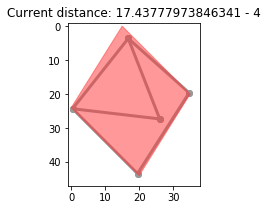

[[0.48930299706953306, 0.5884023382481729], (0, 0)]
[19.510697002930467, 43.41159766175183] [0.48930299706953306, 0.5884023382481729]
[[0.2806395840490765, 0.3733983518295041], (0, 0)]
[34.71936041595092, 19.626601648170496] [0.2806395840490765, 0.3733983518295041]
[[-0.3955770848051732, -0.3152517994151296], (0, 0)]
[0.3955770848051732, 24.31525179941513] [-0.3955770848051732, -0.3152517994151296]
[[-1.777662114210191, -3.6356584794540794], (0, 0)]
[16.77766211421019, 3.6356584794540794] [-1.777662114210191, -3.6356584794540794]
[(0, 0)]
[26.04454062767572, 27.314018413541937] (0, 0)


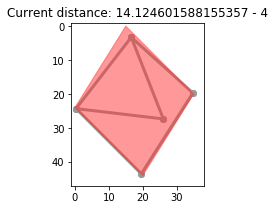

[[0.4403726973625801, 0.5295621044233556], (0, 0)]
[19.55962730263742, 43.470437895576644] [0.4403726973625801, 0.5295621044233556]
[[0.2525756256441696, 0.3360585166465526], (0, 0)]
[34.74742437435583, 19.663941483353447] [0.2525756256441696, 0.3360585166465526]
[[-0.35601937632465586, -0.2837266194736152], (0, 0)]
[0.35601937632465586, 24.283726619473615] [-0.35601937632465586, -0.2837266194736152]
[[-1.5998959027891715, -3.2720926315086714], (0, 0)]
[16.59989590278917, 3.2720926315086714] [-1.5998959027891715, -3.2720926315086714]
[(0, 0)]
[26.04454062767572, 27.314018413541937] (0, 0)


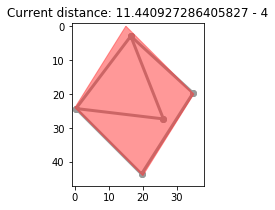

[[0.39633542762632246, 0.4766058939810165], (0, 0)]
[19.603664572373678, 43.52339410601898] [0.39633542762632246, 0.4766058939810165]
[[0.22731806307974978, 0.30245266498189594], (0, 0)]
[34.77268193692025, 19.697547335018104] [0.22731806307974978, 0.30245266498189594]
[[-0.32041743869219025, -0.25535395752625334], (0, 0)]
[0.32041743869219025, 24.255353957526253] [-0.32041743869219025, -0.25535395752625334]
[[-1.439906312510253, -2.944883368357804], (0, 0)]
[16.439906312510253, 2.944883368357804] [-1.439906312510253, -2.944883368357804]
[(0, 0)]
[26.04454062767572, 27.314018413541937] (0, 0)


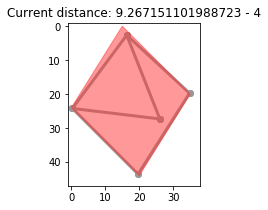

[[0.35670188486368914, 0.4289453045829177], (0, 0)]
[19.64329811513631, 43.57105469541708] [0.35670188486368914, 0.4289453045829177]
[[0.20458625677177622, 0.2722073984837081], (0, 0)]
[34.795413743228224, 19.727792601516292] [0.20458625677177622, 0.2722073984837081]
[[-0.2883756948229712, -0.22981856177362658], (0, 0)]
[0.2883756948229712, 24.229818561773627] [-0.2883756948229712, -0.22981856177362658]
[[-1.2959156812592276, -2.6503950315220237], (0, 0)]
[16.295915681259228, 2.6503950315220237] [-1.2959156812592276, -2.6503950315220237]
[(0, 0)]
[26.04454062767572, 27.314018413541937] (0, 0)


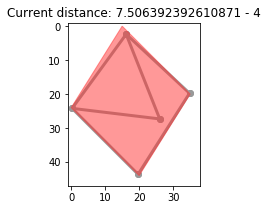

[[0.32103169637732165, 0.38605077412462663], (0, 0)]
[19.67896830362268, 43.61394922587537] [0.32103169637732165, 0.38605077412462663]
[[0.18412763109459718, 0.2449866586353373], (0, 0)]
[34.8158723689054, 19.755013341364663] [0.18412763109459718, 0.2449866586353373]
[[-0.2595381253406741, -0.20683670559626322], (0, 0)]
[0.2595381253406741, 24.206836705596263] [-0.2595381253406741, -0.20683670559626322]
[[-1.1663241131333066, -2.3853555283698213], [2.4086964105364648, 6.078585210456804], (0, 0)]
[16.166324113133307, 2.3853555283698213] [1.2423722974031581, 3.693229682086983]
[[-2.4086964105364648, -6.078585210456804], (0, 0)]
[26.04454062767572, 27.314018413541937] [-2.4086964105364648, -6.078585210456804]


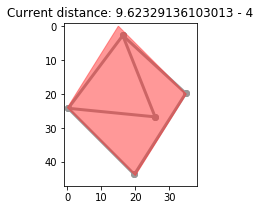

[[0.28892852673958913, 0.34744569671216397], (0, 0)]
[19.71107147326041, 43.652554303287836] [0.28892852673958913, 0.34744569671216397]
[[0.16571486798513746, 0.22048799277180464], (0, 0)]
[34.83428513201486, 19.779512007228195] [0.16571486798513746, 0.22048799277180464]
[[-0.2335843128066067, -0.18615303503663583], (0, 0)]
[0.2335843128066067, 24.186153035036636] [-0.2335843128066067, -0.18615303503663583]
[[-1.2905613428736231, -2.75467849657852], (0, 0)]
[16.290561342873623, 2.75467849657852] [-1.2905613428736231, -2.75467849657852]
[(0, 0)]
[25.803670986622073, 26.706159892496256] (0, 0)


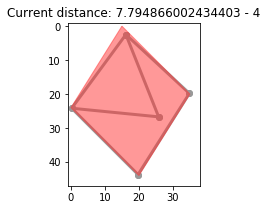

[[0.2600356740656302, 0.31270112704094544], (0, 0)]
[19.73996432593437, 43.687298872959055] [0.2600356740656302, 0.31270112704094544]
[[0.14914338118662585, 0.19843919349462524], (0, 0)]
[34.850856618813374, 19.801560806505375] [0.14914338118662585, 0.19843919349462524]
[[-0.210225881525946, -0.16753773153297402], (0, 0)]
[0.210225881525946, 24.167537731532974] [-0.210225881525946, -0.16753773153297402]
[[-1.1615052085862594, -2.479210646920668], (0, 0)]
[16.16150520858626, 2.479210646920668] [-1.1615052085862594, -2.479210646920668]
[(0, 0)]
[25.803670986622073, 26.706159892496256] (0, 0)


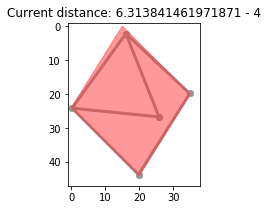

[[0.23403210665906826, 0.281431014336853], [0.15099803063591108, -0.2389716425980831], (0, 0)]
[19.76596789334093, 43.71856898566315] [0.38503013729497937, 0.04245937173876993]
[[0.13422904306796113, 0.17859527414516307], [-0.15099803063591108, 0.2389716425980831], (0, 0)]
[34.86577095693204, 19.821404725854837] [-0.01676898756794995, 0.4175669167432462]
[[-0.1892032933733514, -0.15078395837967662], (0, 0)]
[0.1892032933733514, 24.150783958379677] [-0.1892032933733514, -0.15078395837967662]
[[-1.0453546877276345, -2.231289582228601], (0, 0)]
[16.045354687727635, 2.231289582228601] [-1.0453546877276345, -2.231289582228601]
[(0, 0)]
[25.803670986622073, 26.706159892496256] (0, 0)


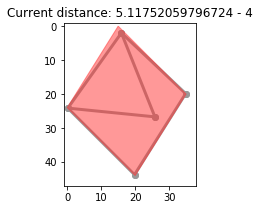

[[0.19552909292956855, 0.2771850771629758], (0, 0)]
[19.80447090707043, 43.722814922837024] [0.19552909292956855, 0.2771850771629758]
[[0.13590594182475257, 0.1368385824708369], (0, 0)]
[34.86409405817525, 19.863161417529163] [0.13590594182475257, 0.1368385824708369]
[[-0.17028296403601625, -0.13570556254170896], (0, 0)]
[0.17028296403601625, 24.13570556254171] [-0.17028296403601625, -0.13570556254170896]
[[-0.9408192189548714, -2.008160624005741], [0.23504794726408143, 0.588593863756461], (0, 0)]
[15.940819218954871, 2.008160624005741] [-0.70577127169079, -1.41956676024928]
[[-0.23504794726408143, -0.588593863756461], (0, 0)]
[25.803670986622073, 26.706159892496256] [-0.23504794726408143, -0.588593863756461]


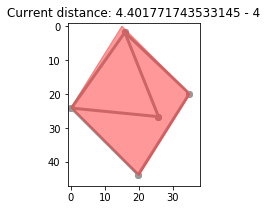

[[0.17597618363661027, 0.24946656944668177], (0, 0)]
[19.82402381636339, 43.75053343055332] [0.17597618363661027, 0.24946656944668177]
[[0.12231534764227803, 0.12315472422375251], (0, 0)]
[34.87768465235772, 19.876845275776247] [0.12231534764227803, 0.12315472422375251]
[[-0.15325466763241463, -0.12213500628753948], (0, 0)]
[0.15325466763241463, 24.12213500628754] [-0.15325466763241463, -0.12213500628753948]
[[-0.8702420917857925, -1.866203947980813], [1.1739646296727924, 2.9356562724269244], (0, 0)]
[15.870242091785792, 1.866203947980813] [0.3037225378869999, 1.0694523244461114]
[[-1.1739646296727924, -2.9356562724269244], (0, 0)]
[25.780166191895667, 26.64730050612061] [-1.1739646296727924, -2.9356562724269244]


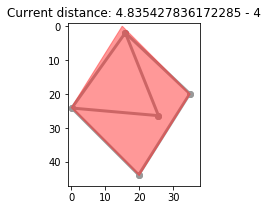

[[0.15837856527294747, 0.22451991250201075], (0, 0)]
[19.841621434727053, 43.77548008749799] [0.15837856527294747, 0.22451991250201075]
[[0.11008381287805236, 0.11083925180137655], (0, 0)]
[34.88991618712195, 19.889160748198623] [0.11008381287805236, 0.11083925180137655]
[[-0.13792920086917318, -0.10992150565878589], (0, 0)]
[0.13792920086917318, 24.109921505658786] [-0.13792920086917318, -0.10992150565878589]
[[-0.9006143455744926, -1.9731491804254242], (0, 0)]
[15.900614345574493, 1.9731491804254242] [-0.9006143455744926, -1.9731491804254242]
[(0, 0)]
[25.66276972892839, 26.35373487887792] (0, 0)


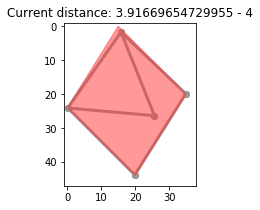

[[0.14254070874565272, 0.2020679212518104], (0, 0)]
[19.857459291254347, 43.79793207874819] [0.14254070874565272, 0.2020679212518104]
[[0.09907543159025067, 0.09975532662123854], (0, 0)]
[34.90092456840975, 19.90024467337876] [0.09907543159025067, 0.09975532662123854]
[[-0.12413628078225586, -0.09892935509290623], (0, 0)]
[0.12413628078225586, 24.098929355092906] [-0.12413628078225586, -0.09892935509290623]
[[-0.8105529110170426, -1.7758342623828818], (0, 0)]
[15.810552911017043, 1.7758342623828818] [-0.8105529110170426, -1.7758342623828818]
[(0, 0)]
[25.66276972892839, 26.35373487887792] (0, 0)


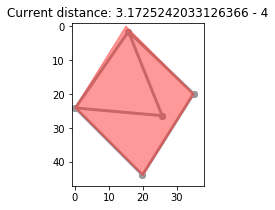

[[0.12828663787108852, 0.18186112912663077], (0, 0)]
[19.87171336212891, 43.81813887087337] [0.12828663787108852, 0.18186112912663077]
[[0.08916788843122703, 0.08977979395911362], (0, 0)]
[34.91083211156877, 19.910220206040886] [0.08916788843122703, 0.08977979395911362]
[[-0.11172265270403027, -0.08903641958361419], (0, 0)]
[0.11172265270403027, 24.089036419583614] [-0.11172265270403027, -0.08903641958361419]
[[-0.7294976199153389, -1.5982508361445935], [1.0267988505686907, 2.558965694424706], (0, 0)]
[15.729497619915339, 1.5982508361445935] [0.2973012306533518, 0.9607148582801124]
[[-1.0267988505686907, -2.558965694424706], (0, 0)]
[25.66276972892839, 26.35373487887792] [-1.0267988505686907, -2.558965694424706]


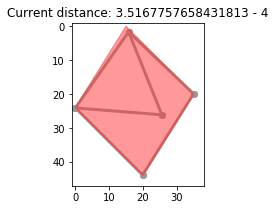

[[0.11545797408398073, 0.16367501621396485], (0, 0)]
[19.88454202591602, 43.836324983786035] [0.11545797408398073, 0.16367501621396485]
[[0.08025109958810361, 0.0808018145632019], (0, 0)]
[34.919748900411896, 19.919198185436798] [0.08025109958810361, 0.0808018145632019]
[[-0.10055038743362724, -0.08013277762525206], (0, 0)]
[0.10055038743362724, 24.080132777625252] [-0.10055038743362724, -0.08013277762525206]
[[-0.7592277429806735, -1.6943223219726047], (0, 0)]
[15.759227742980674, 1.6943223219726047] [-0.7592277429806735, -1.6943223219726047]
[(0, 0)]
[25.56008984387152, 26.09783830943545] (0, 0)


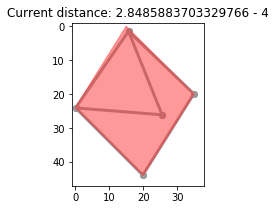

[[0.10391217667558195, 0.14730751459256908], (0, 0)]
[19.896087823324418, 43.85269248540743] [0.10391217667558195, 0.14730751459256908]
[[0.07222598962929538, 0.07272163310688029], (0, 0)]
[34.927774010370705, 19.92727836689312] [0.07222598962929538, 0.07272163310688029]
[[-0.09049534869026452, -0.07211949986272614], (0, 0)]
[0.09049534869026452, 24.072119499862726] [-0.09049534869026452, -0.07211949986272614]
[[-0.6833049686826058, -1.5248900897753441], (0, 0)]
[15.683304968682606, 1.5248900897753441] [-0.6833049686826058, -1.5248900897753441]
[(0, 0)]
[25.56008984387152, 26.09783830943545] (0, 0)


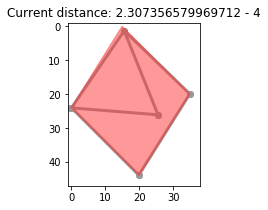

[[0.09352095900802482, 0.132576763133315], (0, 0)]
[19.906479040991975, 43.867423236866685] [0.09352095900802482, 0.132576763133315]
[[0.06500339066636229, 0.06544946979619226], (0, 0)]
[34.93499660933364, 19.934550530203808] [0.06500339066636229, 0.06544946979619226]
[[-0.08144581382123807, -0.06490754987645175], (0, 0)]
[0.08144581382123807, 24.06490754987645] [-0.08144581382123807, -0.06490754987645175]
[[-0.614974471814346, -1.3724010807978098], [0.7946502346276114, 1.9756507350545618], (0, 0)]
[15.614974471814346, 1.3724010807978098] [0.17967576281326547, 0.603249654256752]
[[-0.7946502346276114, -1.9756507350545618], (0, 0)]
[25.56008984387152, 26.09783830943545] [-0.7946502346276114, -1.9756507350545618]


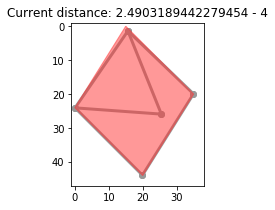

[[0.08416886310722305, 0.11931908681998493], (0, 0)]
[19.915831136892777, 43.880680913180015] [0.08416886310722305, 0.11931908681998493]
[[0.058503051599728906, 0.058904522816572324], (0, 0)]
[34.94149694840027, 19.941095477183428] [0.058503051599728906, 0.058904522816572324]
[[-0.07330123243911427, -0.05841679488880658], (0, 0)]
[0.07330123243911427, 24.058416794888807] [-0.07330123243911427, -0.05841679488880658]
[[-0.6329420480956731, -1.432726046223485], (0, 0)]
[15.632942048095673, 1.432726046223485] [-0.6329420480956731, -1.432726046223485]
[(0, 0)]
[25.48062482040876, 25.900273235929994] (0, 0)


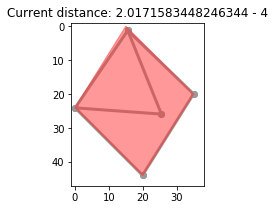

[[0.07575197679650003, 0.1073871781379836], [0.15023099230356746, -0.23945626892396932], (0, 0)]
[19.9242480232035, 43.892612821862016] [0.2259829691000675, -0.13206909078598572]
[[0.052652746439754594, 0.053014070534914026], [-0.15023099230356746, 0.23945626892396932], (0, 0)]
[34.947347253560245, 19.946985929465086] [-0.09757824586381286, 0.29247033945888334]
[[-0.06597110919520284, -0.05257511539992521], (0, 0)]
[0.06597110919520284, 24.052575115399925] [-0.06597110919520284, -0.05257511539992521]
[[-0.5696478432861056, -1.2894534416011365], (0, 0)]
[15.569647843286106, 1.2894534416011365] [-0.5696478432861056, -1.2894534416011365]
[(0, 0)]
[25.48062482040876, 25.900273235929994] (0, 0)


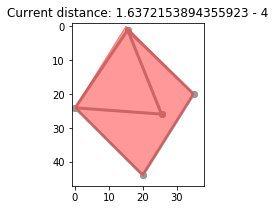

[[0.053153679886492, 0.12059408721658116], (0, 0)]
[19.946846320113508, 43.87940591278342] [0.053153679886492, 0.12059408721658116]
[[0.062410571026134676, 0.02376703658902457], (0, 0)]
[34.937589428973865, 19.976232963410975] [0.062410571026134676, 0.02376703658902457]
[[-0.05937399827568256, -0.04731760385993411], (0, 0)]
[0.05937399827568256, 24.047317603859934] [-0.05937399827568256, -0.04731760385993411]
[[-0.5126830589574958, -1.160508097441023], [1.0139315493779057, 2.5165103286539967], (0, 0)]
[15.512683058957496, 1.160508097441023] [0.50124849042041, 1.3560022312129738]
[[-1.0139315493779057, -2.5165103286539967], (0, 0)]
[25.48062482040876, 25.900273235929994] [-1.0139315493779057, -2.5165103286539967]


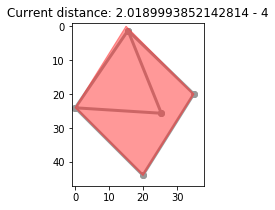

[[0.04783831189784138, 0.10853467849491949], (0, 0)]
[19.95216168810216, 43.89146532150508] [0.04783831189784138, 0.10853467849491949]
[[0.05616951392352121, 0.021390332930121048], (0, 0)]
[34.94383048607648, 19.97860966706988] [0.05616951392352121, 0.021390332930121048]
[[-0.0534365984481143, -0.042585843473940344], (0, 0)]
[0.0534365984481143, 24.04258584347394] [-0.0534365984481143, -0.042585843473940344]
[[-0.5628079079995363, -1.2961083205623203], (0, 0)]
[15.562807907999536, 1.2961083205623203] [-0.5628079079995363, -1.2961083205623203]
[(0, 0)]
[25.379231665470968, 25.648622203064594] (0, 0)


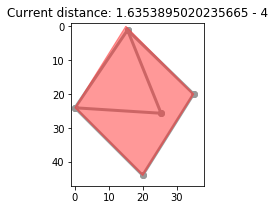

[[0.04305448070805795, 0.09768121064542612], (0, 0)]
[19.956945519291942, 43.902318789354574] [0.04305448070805795, 0.09768121064542612]
[[0.050552562531166245, 0.019251299637108588], (0, 0)]
[34.949447437468834, 19.98074870036289] [0.050552562531166245, 0.019251299637108588]
[[-0.04809293860330287, -0.038327259126546664], (0, 0)]
[0.04809293860330287, 24.038327259126547] [-0.04809293860330287, -0.038327259126546664]
[[-0.5065271171995818, -1.1664974885060881], (0, 0)]
[15.506527117199582, 1.1664974885060881] [-0.5065271171995818, -1.1664974885060881]
[(0, 0)]
[25.379231665470968, 25.648622203064594] (0, 0)


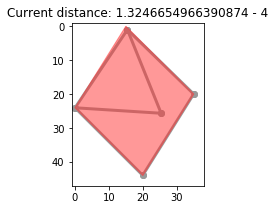

[[0.038749032637252157, 0.08791308958087996], (0, 0)]
[19.961250967362748, 43.91208691041912] [0.038749032637252157, 0.08791308958087996]
[[0.04549730627805104, 0.017326169673395952], (0, 0)]
[34.95450269372195, 19.982673830326604] [0.04549730627805104, 0.017326169673395952]
[[-0.04328364474297258, -0.03449453321389129], (0, 0)]
[0.04328364474297258, 24.03449453321389] [-0.04328364474297258, -0.03449453321389129]
[[-0.4558744054796229, -1.0498477396554793], (0, 0)]
[15.455874405479623, 1.0498477396554793] [-0.4558744054796229, -1.0498477396554793]
[(0, 0)]
[25.379231665470968, 25.648622203064594] (0, 0)


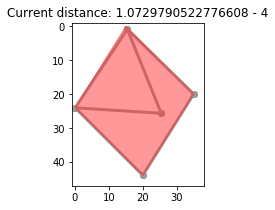

[[0.034874129373527296, 0.07912178062279196], (0, 0)]
[19.965125870626473, 43.92087821937721] [0.034874129373527296, 0.07912178062279196]
[[0.040947575650243095, 0.015593552706057778], (0, 0)]
[34.95905242434976, 19.984406447293942] [0.040947575650243095, 0.015593552706057778]
[[-0.03895528026867533, -0.031045079892500382], (0, 0)]
[0.03895528026867533, 24.0310450798925] [-0.03895528026867533, -0.031045079892500382]
[[-0.41028696493166095, -0.9448629656899313], [0.6848759417795887, 1.697171654716661], (0, 0)]
[15.410286964931661, 0.9448629656899313] [0.2745889768479277, 0.7523086890267298]
[[-0.6848759417795887, -1.697171654716661], (0, 0)]
[25.379231665470968, 25.648622203064594] [-0.6848759417795887, -1.697171654716661]


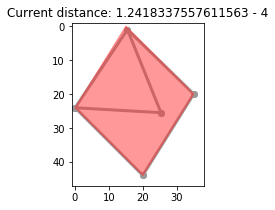

[[0.031386716436173856, 0.0712096025605149], (0, 0)]
[19.968613283563826, 43.928790397439485] [0.031386716436173856, 0.0712096025605149]
[[0.03685281808522234, 0.014034197435453422], (0, 0)]
[34.96314718191478, 19.985965802564547] [0.03685281808522234, 0.014034197435453422]
[[-0.035059752241807796, -0.027940571903251055], (0, 0)]
[0.035059752241807796, 24.02794057190325] [-0.035059752241807796, -0.027940571903251055]
[[-0.4377458626164543, -1.0200938345926043], (0, 0)]
[15.437745862616454, 1.0200938345926043] [-0.4377458626164543, -1.0200938345926043]
[(0, 0)]
[25.31074407129301, 25.478905037592927] (0, 0)


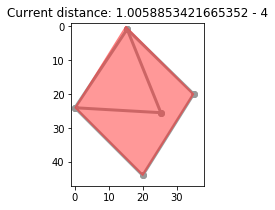

[[0.02824804479255505, 0.06408864230446198], (0, 0)]
[19.971751955207445, 43.93591135769554] [0.02824804479255505, 0.06408864230446198]
[[0.033167536276700105, 0.012630777691907014], (0, 0)]
[34.9668324637233, 19.987369222308093] [0.033167536276700105, 0.012630777691907014]
[[-0.031553777017627016, -0.02514651471292595], (0, 0)]
[0.031553777017627016, 24.025146514712926] [-0.031553777017627016, -0.02514651471292595]
[[-0.393971276354808, -0.9180844511333438], (0, 0)]
[15.393971276354808, 0.9180844511333438] [-0.393971276354808, -0.9180844511333438]
[(0, 0)]
[25.31074407129301, 25.478905037592927] (0, 0)


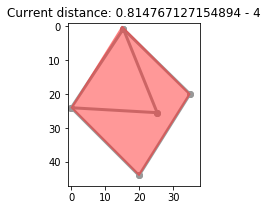

[[0.025423240313298123, 0.05767977807401792], (0, 0)]
[19.974576759686702, 43.94232022192598] [0.025423240313298123, 0.05767977807401792]
[[0.029850782649027963, 0.011367699922715246], (0, 0)]
[34.97014921735097, 19.988632300077285] [0.029850782649027963, 0.011367699922715246]
[[-0.028398399315864315, -0.02263186324163513], (0, 0)]
[0.028398399315864315, 24.022631863241635] [-0.028398399315864315, -0.02263186324163513]
[[-0.3545741487193279, -0.8262760060200094], [0.09956169922573681, 0.24652629031572917], (0, 0)]
[15.354574148719328, 0.8262760060200094] [-0.2550124494935911, -0.5797497157042802]
[[-0.09956169922573681, -0.24652629031572917], (0, 0)]
[25.31074407129301, 25.478905037592927] [-0.09956169922573681, -0.24652629031572917]


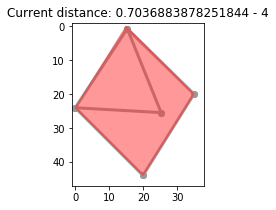

[[0.022880916281970087, 0.051911800266616126], (0, 0)]
[19.97711908371803, 43.948088199733384] [0.022880916281970087, 0.051911800266616126]
[[0.026865704384121614, 0.010230929930443722], (0, 0)]
[34.97313429561588, 19.989769070069556] [0.026865704384121614, 0.010230929930443722]
[[-0.025558559384277882, -0.020368676917470907], (0, 0)]
[0.025558559384277882, 24.02036867691747] [-0.025558559384277882, -0.020368676917470907]
[[-0.3290729037699691, -0.7683010344495813], [0.5307474383667097, 1.3139169599820864], (0, 0)]
[15.32907290376997, 0.7683010344495813] [0.20167453459674056, 0.545615925532505]
[[-0.5307474383667097, -1.3139169599820864], (0, 0)]
[25.300787901370434, 25.454252408561356] [-0.5307474383667097, -1.3139169599820864]


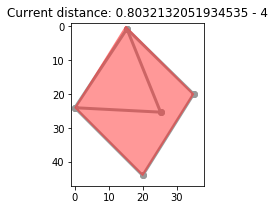

[[0.020592824653771657, 0.04672062023995238], [0.14996413690708063, -0.23962487216697448], (0, 0)]
[19.97940717534623, 43.95327937976005] [0.1705569615608523, -0.1929042519270221]
[[0.02417913394570803, 0.00920783693739935], [-0.14996413690708063, 0.23962487216697448], (0, 0)]
[34.97582086605429, 19.9907921630626] [-0.1257850029613726, 0.24883270910437383]
[[-0.023002703445850092, -0.018331809225724527], (0, 0)]
[0.023002703445850092, 24.018331809225725] [-0.023002703445850092, -0.018331809225724527]
[[-0.3492403572296432, -0.8228626270028319], (0, 0)]
[15.349240357229643, 0.8228626270028319] [-0.3492403572296432, -0.8228626270028319]
[(0, 0)]
[25.247713157533763, 25.32286071256315] (0, 0)


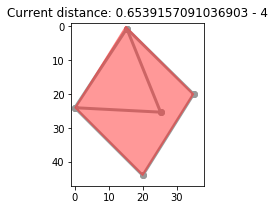

[[0.0035371284976868367, 0.06601104543265279], (0, 0)]
[19.996462871502313, 43.93398895456735] [0.0035371284976868367, 0.06601104543265279]
[[0.03675763424184453, -0.015675433973036945], (0, 0)]
[34.963242365758155, 20.015675433973037] [0.03675763424184453, -0.015675433973036945]
[[-0.020702433101265082, -0.01649862830315385], (0, 0)]
[0.020702433101265082, 24.016498628303154] [-0.020702433101265082, -0.01649862830315385]
[[-0.3143163215066789, -0.7405763643025487], (0, 0)]
[15.314316321506679, 0.7405763643025487] [-0.3143163215066789, -0.7405763643025487]
[(0, 0)]
[25.247713157533763, 25.32286071256315] (0, 0)


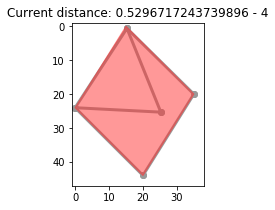

[[0.0031834156479177977, 0.059409940889388224], (0, 0)]
[19.996816584352082, 43.94059005911061] [0.0031834156479177977, 0.059409940889388224]
[[0.033081870817660786, -0.01410789057573325], (0, 0)]
[34.96691812918234, 20.014107890575733] [0.033081870817660786, -0.01410789057573325]
[[-0.018632189791138575, -0.014848765472837755], (0, 0)]
[0.018632189791138575, 24.014848765472838] [-0.018632189791138575, -0.014848765472837755]
[[-0.2828846893560115, -0.6665187278722938], [0.23110712714498927, 0.5718368740800126], (0, 0)]
[15.282884689356012, 0.6665187278722938] [-0.051777562211022254, -0.09468185379228122]
[[-0.23110712714498927, -0.5718368740800126], (0, 0)]
[25.247713157533763, 25.32286071256315] [-0.23110712714498927, -0.5718368740800126]


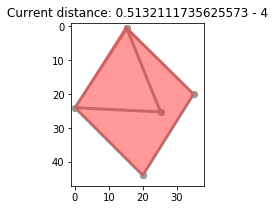

[[0.0028650740831253074, 0.05346894680045011], (0, 0)]
[19.997134925916875, 43.94653105319955] [0.0028650740831253074, 0.05346894680045011]
[[0.02977368373589684, -0.012697101518160281], (0, 0)]
[34.9702263162641, 20.01269710151816] [0.02977368373589684, -0.012697101518160281]
[[-0.01676897081202472, -0.013363888925553624], (0, 0)]
[0.01676897081202472, 24.013363888925554] [-0.01676897081202472, -0.013363888925553624]
[[-0.27770693313491, -0.6570505424930657], (0, 0)]
[15.27770693313491, 0.6570505424930657] [-0.27770693313491, -0.6570505424930657]
[(0, 0)]
[25.224602444819265, 25.265677025155146] (0, 0)


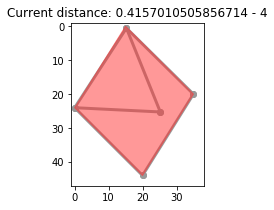

[[0.0025785666748134872, 0.0481220521204051], (0, 0)]
[19.997421433325187, 43.951877947879595] [0.0025785666748134872, 0.0481220521204051]
[[0.026796315362304313, -0.011427391366343187], (0, 0)]
[34.973203684637696, 20.011427391366343] [0.026796315362304313, -0.011427391366343187]
[[-0.015092073730822247, -0.012027500032999683], (0, 0)]
[0.015092073730822247, 24.012027500033] [-0.015092073730822247, -0.012027500032999683]
[[-0.24993623982141955, -0.5913454882437591], [0.43447196328210813, 1.0747532844902696], (0, 0)]
[15.24993623982142, 0.5913454882437591] [0.18453572346068858, 0.48340779624651053]
[[-0.43447196328210813, -1.0747532844902696], (0, 0)]
[25.224602444819265, 25.265677025155146] [-0.43447196328210813, -1.0747532844902696]


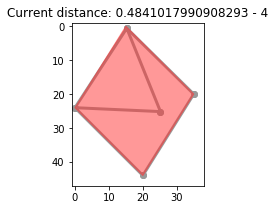

[[0.0023207100073321385, 0.04330984690836459], (0, 0)]
[19.997679289992668, 43.956690153091635] [0.0023207100073321385, 0.04330984690836459]
[[0.02411668382607246, -0.010284652229707092], (0, 0)]
[34.97588331617393, 20.010284652229707] [0.02411668382607246, -0.010284652229707092]
[[-0.013582866357740022, -0.010824750029698293], (0, 0)]
[0.013582866357740022, 24.0108247500297] [-0.013582866357740022, -0.010824750029698293]
[[-0.2683898121674879, -0.6396862678684101], (0, 0)]
[15.268389812167488, 0.6396862678684101] [-0.2683898121674879, -0.6396862678684101]
[(0, 0)]
[25.181155248491056, 25.15820169670612] (0, 0)


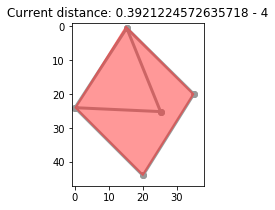

[[0.0020886390065975036, 0.038978862217526], (0, 0)]
[19.997911360993402, 43.961021137782474] [0.0020886390065975036, 0.038978862217526]
[[0.021705015443465925, -0.009256187006737804], (0, 0)]
[34.978294984556534, 20.009256187006738] [0.021705015443465925, -0.009256187006737804]
[[-0.012224579721966021, -0.009742275026727754], (0, 0)]
[0.012224579721966021, 24.009742275026728] [-0.012224579721966021, -0.009742275026727754]
[[-0.24155083095073948, -0.5757176410815691], (0, 0)]
[15.24155083095074, 0.5757176410815691] [-0.24155083095073948, -0.5757176410815691]
[(0, 0)]
[25.181155248491056, 25.15820169670612] (0, 0)


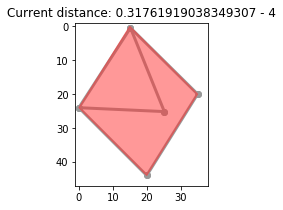

[[0.001879775105937398, 0.03508097599577553], (0, 0)]
[19.998120224894063, 43.964919024004224] [0.001879775105937398, 0.03508097599577553]
[[0.0195345138991172, -0.008330568306064379], (0, 0)]
[34.98046548610088, 20.008330568306064] [0.0195345138991172, -0.008330568306064379]
[[-0.011002121749769419, -0.008768047524053912], (0, 0)]
[0.011002121749769419, 24.008768047524054] [-0.011002121749769419, -0.008768047524053912]
[[-0.21739574785566518, -0.5181458769734122], [0.09963759500635391, 0.24640055819732706], (0, 0)]
[15.217395747855665, 0.5181458769734122] [-0.11775815284931127, -0.2717453187760851]
[[-0.09963759500635391, -0.24640055819732706], (0, 0)]
[25.181155248491056, 25.15820169670612] [-0.09963759500635391, -0.24640055819732706]


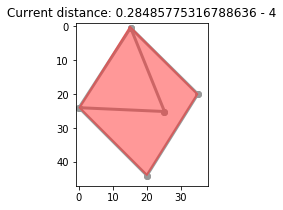

[[0.0016917975953418818, 0.03157287839619727], (0, 0)]
[19.998308202404658, 43.9684271216038] [0.0016917975953418818, 0.03157287839619727]
[[0.017581062509208323, -0.00749751147545652], (0, 0)]
[34.98241893749079, 20.007497511475457] [0.017581062509208323, -0.00749751147545652]
[[-0.009901909574792476, -0.007891242771648876], (0, 0)]
[0.009901909574792476, 24.00789124277165] [-0.009901909574792476, -0.007891242771648876]
[[-0.20561993257073397, -0.4909713450958037], [0.09965571556419686, 0.2464259029579058], (0, 0)]
[15.205619932570734, 0.4909713450958037] [-0.1059642170065371, -0.2445454421378979]
[[-0.09965571556419686, -0.2464259029579058], (0, 0)]
[25.17119148899042, 25.133561640886384] [-0.09965571556419686, -0.2464259029579058]


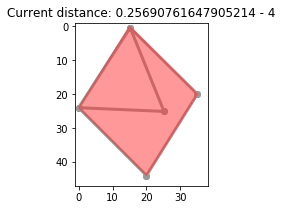

[[0.001522617835806983, 0.02841559055657683], (0, 0)]
[19.998477382164193, 43.97158440944342] [0.001522617835806983, 0.02841559055657683]
[[0.015822956258290333, -0.006747760327911578], (0, 0)]
[34.98417704374171, 20.00674776032791] [0.015822956258290333, -0.006747760327911578]
[[-0.008911718617313229, -0.007102118494483278], (0, 0)]
[0.008911718617313229, 24.007102118494483] [-0.008911718617313229, -0.007102118494483278]
[[-0.19502351087007952, -0.4665168008820139], [0.09966202406563919, 0.24642402249708578], (0, 0)]
[15.19502351087008, 0.4665168008820139] [-0.09536148680444033, -0.22009277838492813]
[[-0.09966202406563919, -0.24642402249708578], (0, 0)]
[25.161225917434, 25.108919050590593] [-0.09966202406563919, -0.24642402249708578]


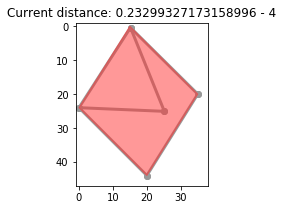

[[0.0013703560522273506, 0.025574031500916306], [0.14987129695419768, -0.23968352984203964], (0, 0)]
[19.998629643947773, 43.974425968499084] [0.15124165300642503, -0.21410949834112333]
[[0.014240660632459878, -0.00607298429511971], [-0.14987129695419768, 0.23968352984203964], (0, 0)]
[34.98575933936754, 20.00607298429512] [-0.1356306363217378, 0.23361054554691993]
[[-0.008020546755581906, -0.006391906645035306], (0, 0)]
[0.008020546755581906, 24.006391906645035] [-0.008020546755581906, -0.006391906645035306]
[[-0.1854873621896349, -0.4445075230435211], [0.09965772352837801, 0.24639769125297367], (0, 0)]
[15.185487362189635, 0.4445075230435211] [-0.0858296386612569, -0.19810983179054742]
[[-0.09965772352837801, -0.24639769125297367], (0, 0)]
[25.151259715027436, 25.084276648340886] [-0.09965772352837801, -0.24639769125297367]


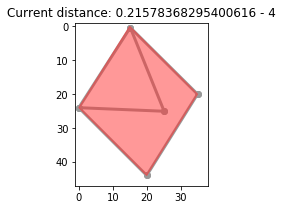

[[-0.013753809248413518, 0.046984981335029374], (0, 0)]
[20.013753809248414, 43.95301501866497] [-0.013753809248413518, 0.046984981335029374]
[[0.027803724264636287, -0.029434038849810662], (0, 0)]
[34.972196275735364, 20.02943403884981] [0.027803724264636287, -0.029434038849810662]
[[-0.007218492080023715, -0.005752715980531065], (0, 0)]
[0.007218492080023715, 24.00575271598053] [-0.007218492080023715, -0.005752715980531065]
[[-0.17690439832350968, -0.42469653986446637], [0.09964389544351088, 0.24634940339351122], (0, 0)]
[15.17690439832351, 0.42469653986446637] [-0.0772605028799988, -0.17834713647095515]
[[-0.09964389544351088, -0.24634940339351122], (0, 0)]
[25.141293942674597, 25.05963687921559] [-0.09964389544351088, -0.24634940339351122]


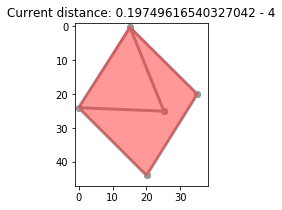

[[-0.012378428323572166, 0.04228648320152928], (0, 0)]
[20.012378428323572, 43.95771351679847] [-0.012378428323572166, 0.04228648320152928]
[[0.025023351838171948, -0.02649063496482995], (0, 0)]
[34.97497664816183, 20.02649063496483] [0.025023351838171948, -0.02649063496482995]
[[-0.0064966428720213435, -0.005177444382479024], (0, 0)]
[0.0064966428720213435, 24.00517744438248] [-0.0064966428720213435, -0.005177444382479024]
[[-0.16917834803551024, -0.4068618262173709], [0.09962151205094737, 0.2462814011265887], (0, 0)]
[15.16917834803551, 0.4068618262173709] [-0.06955683598456287, -0.1605804250907822]
[[-0.09962151205094737, -0.2462814011265887], (0, 0)]
[25.131329553130247, 25.03500193887624] [-0.09962151205094737, -0.2462814011265887]


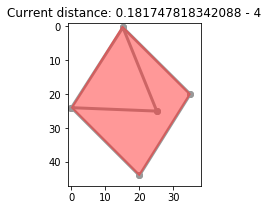

[[-0.01114058549121566, 0.03805783488137848], (0, 0)]
[20.011140585491216, 43.96194216511862] [-0.01114058549121566, 0.03805783488137848]
[[0.02252101665435191, -0.023841571468345535], (0, 0)]
[34.97747898334565, 20.023841571468346] [0.02252101665435191, -0.023841571468345535]
[[-0.00584697858481921, -0.004659699944230766], (0, 0)]
[0.00584697858481921, 24.00465969994423] [-0.00584697858481921, -0.004659699944230766]
[[-0.16222266443705458, -0.39080378370829266], [0.09959144737488097, 0.2461957001505529], (0, 0)]
[15.162222664437055, 0.39080378370829266] [-0.0626312170621736, -0.14460808355773977]
[[-0.09959144737488097, -0.2461957001505529], (0, 0)]
[25.121367401925152, 25.01037379876358] [-0.09959144737488097, -0.2461957001505529]


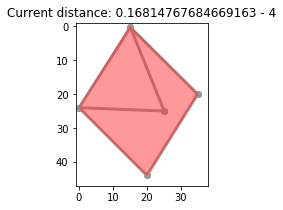

[[-0.01002652694209516, 0.0342520513932385], (0, 0)]
[20.010026526942095, 43.96574794860676] [-0.01002652694209516, 0.0342520513932385]
[[0.02026891498891814, -0.02145741432151027], (0, 0)]
[34.97973108501108, 20.02145741432151] [0.02026891498891814, -0.02145741432151027]
[[-0.005262280726337288, -0.004193729949808045], (0, 0)]
[0.005262280726337288, 24.004193729949808] [-0.005262280726337288, -0.004193729949808045]
[[-0.15595954273083734, -0.3763429753525187], (0, 0)]
[15.155959542730837, 0.3763429753525187] [-0.15595954273083734, -0.3763429753525187]
[(0, 0)]
[25.111408257187662, 24.985754228748526] (0, 0)


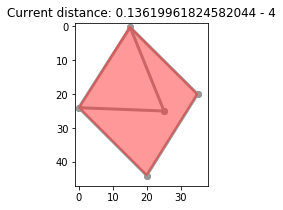

[[-0.00902387424788742, 0.030826846253916074], (0, 0)]
[20.009023874247887, 43.969173153746084] [-0.00902387424788742, 0.030826846253916074]
[[0.018242023490024906, -0.019311672889358533], (0, 0)]
[34.981757976509975, 20.01931167288936] [0.018242023490024906, -0.019311672889358533]
[[-0.004736052653703559, -0.0037743569548283062], (0, 0)]
[0.004736052653703559, 24.00377435695483] [-0.004736052653703559, -0.0037743569548283062]
[[-0.14036358845775432, -0.3387086778172668], [0.1685504527696599, 0.41663344464517965], (0, 0)]
[15.140363588457754, 0.3387086778172668] [0.02818686431190559, 0.07792476682791283]
[[-0.1685504527696599, -0.41663344464517965], (0, 0)]
[25.111408257187662, 24.985754228748526] [-0.1685504527696599, -0.41663344464517965]


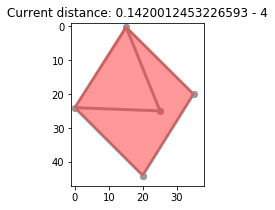

[[-0.0081214868231001, 0.027744161628525887], (0, 0)]
[20.0081214868231, 43.972255838371474] [-0.0081214868231001, 0.027744161628525887]
[[0.016417821141018862, -0.01738050560042126], (0, 0)]
[34.98358217885898, 20.01738050560042] [0.016417821141018862, -0.01738050560042126]
[[-0.004262447388333203, -0.003396921259344765], (0, 0)]
[0.004262447388333203, 24.003396921259345] [-0.004262447388333203, -0.003396921259344765]
[[-0.14318227488894486, -0.3465011545000581], (0, 0)]
[15.143182274888945, 0.3465011545000581] [-0.14318227488894486, -0.3465011545000581]
[(0, 0)]
[25.094553211910696, 24.94409088428401] (0, 0)


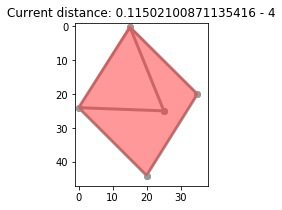

[[-0.007309338140789379, 0.02496974546567543], [-0.2000347313549129, -0.19971973025400913], (0, 0)]
[20.00730933814079, 43.975030254534325] [-0.20734406949570228, -0.1747499847883337]
[[0.014776039026919818, -0.015642455040378422], (0, 0)]
[34.98522396097308, 20.01564245504038] [0.014776039026919818, -0.015642455040378422]
[[-0.003836202649499883, -0.003057229133410999], [0.2000347313549129, 0.19971973025400913], (0, 0)]
[0.003836202649499883, 24.00305722913341] [0.19619852870541302, 0.19666250112059813]
[[-0.1288640474000502, -0.3118510390500523], [0.09965689164510647, 0.24632239845233958], (0, 0)]
[15.12886404740005, 0.3118510390500523] [-0.02920715575494373, -0.06552864059771271]
[[-0.09965689164510647, -0.24632239845233958], (0, 0)]
[25.094553211910696, 24.94409088428401] [-0.09965689164510647, -0.24632239845233958]


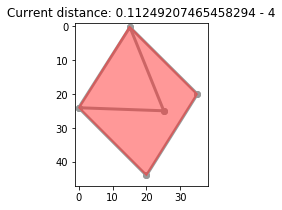

[[0.01342506880878247, 0.04244474394450748], (0, 0)]
[19.986574931191218, 43.95755525605549] [0.01342506880878247, 0.04244474394450748]
[[0.013298435124227126, -0.01407820953633987], (0, 0)]
[34.98670156487577, 20.01407820953634] [0.013298435124227126, -0.01407820953633987]
[[-0.023456055520041187, -0.022723479245470912], (0, 0)]
[0.023456055520041187, 24.02272347924547] [-0.023456055520041187, -0.022723479245470912]
[[-0.12594333182455664, -0.305298174990281], (0, 0)]
[15.125943331824557, 0.305298174990281] [-0.12594333182455664, -0.305298174990281]
[(0, 0)]
[25.084587522746187, 24.919458644438773] (0, 0)


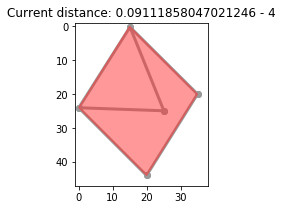

[[0.012082561927904578, 0.038200269550060284], (0, 0)]
[19.987917438072095, 43.96179973044994] [0.012082561927904578, 0.038200269550060284]
[[0.011968591611804413, -0.012670388582705527], (0, 0)]
[34.988031408388196, 20.012670388582706] [0.011968591611804413, -0.012670388582705527]
[[-0.021110449968037067, -0.020451131320925242], (0, 0)]
[0.021110449968037067, 24.020451131320925] [-0.021110449968037067, -0.020451131320925242]
[[-0.1133489986421008, -0.2747683574912529], [0.09971238524104087, 0.24644690286947518], (0, 0)]
[15.1133489986421, 0.2747683574912529] [-0.013636613401059927, -0.02832145462177771]
[[-0.09971238524104087, -0.24644690286947518], (0, 0)]
[25.084587522746187, 24.919458644438773] [-0.09971238524104087, -0.24644690286947518]


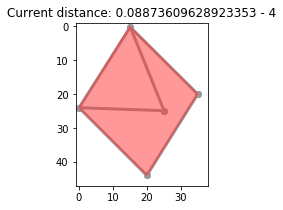

[[0.010874305735114831, 0.03438024259505568], (0, 0)]
[19.989125694264885, 43.965619757404944] [0.010874305735114831, 0.03438024259505568]
[[0.01077173245062113, -0.011403349724435685], (0, 0)]
[34.98922826754938, 20.011403349724436] [0.01077173245062113, -0.011403349724435685]
[[-0.018999404971233362, -0.01840601818883414], (0, 0)]
[0.018999404971233362, 24.018406018188834] [-0.018999404971233362, -0.01840601818883414]
[[-0.111985337301995, -0.27193621202907514], [0.09962630946920087, 0.2462287774212275], (0, 0)]
[15.111985337301995, 0.27193621202907514] [-0.012359027832794134, -0.025707434607847635]
[[-0.09962630946920087, -0.2462287774212275], (0, 0)]
[25.07461628422208, 24.894813954151825] [-0.09962630946920087, -0.2462287774212275]


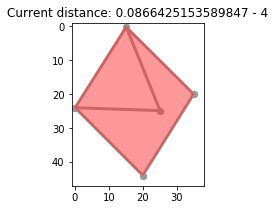

[[0.009786875161601927, 0.030942218335553662], [0.15000092315956046, -0.23958794766912456], (0, 0)]
[19.990213124838398, 43.969057781664446] [0.15978779832116238, -0.2086457293335709]
[[0.009694559205556175, -0.010263014751991761], [-0.15000092315956046, 0.23958794766912456], (0, 0)]
[34.990305440794444, 20.01026301475199] [-0.14030636395400428, 0.2293249329171328]
[[-0.017099464474110027, -0.016565416369950015], (0, 0)]
[0.017099464474110027, 24.01656541636995] [-0.017099464474110027, -0.016565416369950015]
[[-0.11074943451871633, -0.26936546856829036], (0, 0)]
[15.110749434518716, 0.26936546856829036] [-0.11074943451871633, -0.26936546856829036]
[(0, 0)]
[25.064653653275162, 24.870191076409704] (0, 0)


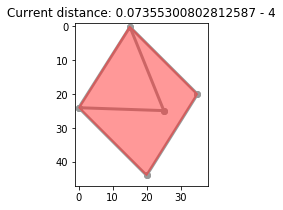

[[-0.006191904670515669, 0.05180679126890908], (0, 0)]
[20.006191904670516, 43.94819320873109] [-0.006191904670515669, 0.05180679126890908]
[[0.02372519560096009, -0.03319550804370408], (0, 0)]
[34.97627480439904, 20.033195508043704] [0.02372519560096009, -0.03319550804370408]
[[-0.015389518026699025, -0.014908874732956434], (0, 0)]
[0.015389518026699025, 24.014908874732956] [-0.015389518026699025, -0.014908874732956434]
[[-0.09967449106684434, -0.24242892171146133], [0.09964979162208318, 0.24627762154698243], (0, 0)]
[15.099674491066844, 0.24242892171146133] [-2.4699444761161482e-05, 0.0038486998355211077]
[[-0.09964979162208318, -0.24627762154698243], (0, 0)]
[25.064653653275162, 24.870191076409704] [-0.09964979162208318, -0.24627762154698243]


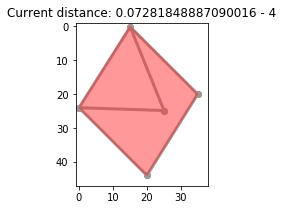

[[-0.005572714203463391, 0.046626112142021725], (0, 0)]
[20.005572714203463, 43.95337388785798] [-0.005572714203463391, 0.046626112142021725]
[[0.02135267604086266, -0.029875957239333673], (0, 0)]
[34.97864732395914, 20.029875957239334] [0.02135267604086266, -0.029875957239333673]
[[-0.013850566224029122, -0.013417987259661146], (0, 0)]
[0.013850566224029122, 24.01341798725966] [-0.013850566224029122, -0.013417987259661146]
[[-0.09967202112236784, -0.24281379169501344], (0, 0)]
[15.099672021122368, 0.24281379169501344] [-0.09967202112236784, -0.24281379169501344]
[(0, 0)]
[25.054688674112953, 24.845563314255006] (0, 0)


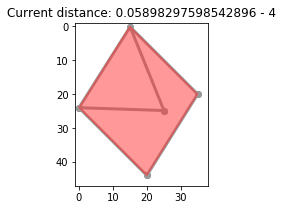

[[-0.005015442783118829, 0.041963500927820974], (0, 0)]
[20.00501544278312, 43.95803649907218] [-0.005015442783118829, 0.041963500927820974]
[[0.019217408436773553, -0.026888361515400305], (0, 0)]
[34.980782591563226, 20.0268883615154] [0.019217408436773553, -0.026888361515400305]
[[-0.01246550960162621, -0.012076188533693966], (0, 0)]
[0.01246550960162621, 24.012076188533694] [-0.01246550960162621, -0.012076188533693966]
[[-0.08970481901013017, -0.2185324125255121], [0.09964983855102823, 0.24627030901729494], (0, 0)]
[15.08970481901013, 0.2185324125255121] [0.009945019540898062, 0.02773789649178285]
[[-0.09964983855102823, -0.24627030901729494], (0, 0)]
[25.054688674112953, 24.845563314255006] [-0.09964983855102823, -0.24627030901729494]


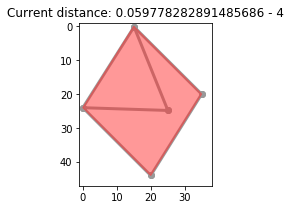

[[-0.004513898504807656, 0.037767150835037455], (0, 0)]
[20.004513898504808, 43.96223284916496] [-0.004513898504807656, 0.037767150835037455]
[[0.017295667593096198, -0.02419952536386205], (0, 0)]
[34.982704332406904, 20.024199525363862] [0.017295667593096198, -0.02419952536386205]
[[-0.011218958641463588, -0.010868569680326345], (0, 0)]
[0.011218958641463588, 24.010868569680326] [-0.011218958641463588, -0.010868569680326345]
[[-0.09069932096421951, -0.22130620217469038], (0, 0)]
[15.09069932096422, 0.22130620217469038] [-0.09069932096421951, -0.22130620217469038]
[(0, 0)]
[25.04472369025785, 24.820936283353277] (0, 0)


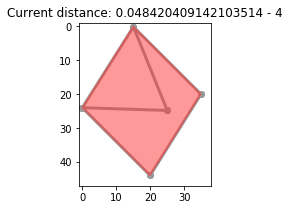

In [651]:
hole_poly = Polygon(data['hole'])
figure = data['figure']
vertices = figure['vertices']
edges = figure['edges']
epsilon=data['epsilon']
figure_shape = MultiLineString([(vertices[s], vertices[e]) for s, e in edges])
delta=0.1
n = len(sources)
# magnets={
#     0:[4],1:[3], 2:[2], 3:[0], 4:[1]
# }

# magnets = {
#     0:[0], 1:[4], 2:[1], 3:[3], 4:[2]
# } # 16
# magnets = {
#     0:[8],  2: [7] #1:[8, 0],
# } # 14
# magnets={
#     0: [3], 1: [0], 2: [2], 3: [1]
# } # 13
#magnets = {
#    0: [2], 1: [0], 2: [0], 3: [1]
#} # 12
magnets = {
#     0: [3],
#     1: [0],
#     2: [2],
#     4: [0, 3],
#     3: [1]
    
#     0: [0],
#     1: [1],
#     2: [3],
#     3: [2],
#     4: [0, 1]
    
#     0: [1],
#     1: [2],
#     2: [0],
#     4: [2, 1],
#     3: [3]
    0: [2],
    1: [1],
    2: [3],
    3: [0],
    4 : [1, 2]
} # 15
# magnets = {
#     #0: [1]
#     1: [0]
# } # 22
32410

current_pos = sources
for k in range(100):
    if k > 40:
        magnets = {k:v for k, v in magnets.items() if len(v)==1}
    forces = compute_forces(current_pos, orig_edges, targets, sources, epsilon, magnets=magnets)
    current_pos = [modify_pos(current_pos[i], delta, forces[i]) for i in range(n)]
    # print(current_pos)
    figure_shape = MultiLineString([(current_pos[s], current_pos[e]) for s, e in edges])

    #if i%2==0:
    draw_pair(hole_poly, figure_shape, filename=None, label=str(i), new_vert=current_pos)

In [653]:
sources

[[0, 20], [20, 0], [20, 40], [40, 20], [49, 45]]

In [654]:
targets

[[15, 0], [35, 20], [20, 44], [0, 24]]

In [655]:
def validate_distance(v, u, new_v, new_u, epsilon=0):
    old_d = get_dist(v, u)
    new_d = get_dist(new_v, new_u)
    return np.abs(new_d/old_d - 1)<= epsilon/1000000
def get_approximated(edges, new_vertices, vertices, epsilon=0):
    neighbors = defaultdict(set)

    for x, y in edges:
        #if x > y:
        neighbors[x].add(y)
        #else:
        neighbors[y].add(x)
    
    sequences = []
    for i, (x, y) in enumerate(new_vertices):
        xa, xb = int(np.floor(x)), int(np.ceil(x))
        ya, yb = int(np.floor(y)), int(np.ceil(y))
        variants = [(xa, ya)]
        if ya != yb:
            variants.append((xa, yb))
        if xa != xb:
            variants.append((xb, ya))
            if ya!=yb:
                variants.append((xb, yb))
        # print(i, variants)
        if i == 0:
            new_sequences = []
            for v in variants:
                new_sequences.append([v])
            sequences = new_sequences
            continue
        new_sequences = []
        for prefix in sequences:
            for v in variants:
                neigh = [s for s in neighbors[i] if s < i]
                val_results = [
                    validate_distance(vertices[s], vertices[i], prefix[s], v, epsilon=epsilon)
                    for s in neigh
                ] + [True]
                if not np.all(val_results):
                    continue

                new_sequences.append(prefix + [v])
                # print(i, prefix, v, neighbors[i])
        sequences = new_sequences
    return sequences

def get_best_sequences(approx_sequences, data):
    new_seq = []
    min_dist = None
    for seq in approx_sequences:
        dist_data = [
            np.min([get_dist(p, q) for q in seq])
            for p in data['hole']
        ]
        dist = np.sum(dist_data)
        if min_dist is None or min_dist > dist:
            min_dist = dist
            new_seq = [seq]
        elif dist == min_dist:
            new_seq.append(seq)
    return min_dist, new_seq

In [656]:
current_pos

[[20.00406250865433, 43.966009564248466],
 [34.98443389916621, 20.021779572827477],
 [0.01009706277731723, 24.009781712712293],
 [15.081629388867798, 0.19917558195722135],
 [25.04472369025785, 24.820936283353277]]

In [657]:
vertices = data['figure']['vertices']
pos_round = [[np.round(x), np.round(y)] for x, y in current_pos]
sequences = get_approximated(edges, current_pos, vertices, epsilon=data['epsilon'])
dist, approx_vertices_seqs = get_best_sequences(sequences, data)

print(dist)
figures = [
    (nvert, MultiLineString([(nvert[s], nvert[e]) for s, e in edges]))
    for nvert in approx_vertices_seqs
]
# figures = [(vert, fig) for vert, fig in figures if check_poly(hole_poly, fig)]
print(figures)
current_pos, targets, {"vertices":[[np.round(x), np.round(y)] for x, y in current_pos]}


None
[]


([[20.00406250865433, 43.966009564248466],
  [34.98443389916621, 20.021779572827477],
  [0.01009706277731723, 24.009781712712293],
  [15.081629388867798, 0.19917558195722135],
  [25.04472369025785, 24.820936283353277]],
 [[15, 0], [35, 20], [20, 44], [0, 24]],
 {'vertices': [[20.0, 44.0],
   [35.0, 20.0],
   [0.0, 24.0],
   [15.0, 0.0],
   [25.0, 25.0]]})

In [610]:
vertices = {"vertices":[[np.round(x), np.round(y)] for x, y in current_pos]}
datadir = f"../solutions/{problem_id}/geom_0"
if not os.path.exists(datadir):
    os.makedirs(datadir)
with open(f"{datadir}/solution.json", 'w') as f:
    json.dump(vertices, f)

In [566]:
current_pos

[[34.99640791682266, 20.0],
 [20.0, 43.99439397022526],
 [15.543027676442609, 1.4513470007709677],
 [0.6250338776119315, 24.150665491705524],
 [26.337941195587977, 30.402678149362192]]

In [567]:
vertices = figure['vertices']
problem_id

15

In [441]:
targets

[[34, 0], [17, 30], [10, 62], [13, 30], [0, 0]]

In [442]:
figure
vs = figure['vertices']
es = figure['edges']

In [443]:
import networkx as nx 
G = nx.Graph()

In [444]:
for i in range(len(vs)):
    G.add_node(i)
for s, e in es:
    weight = get_dist(vs[s], vs[e])
    G.add_edge(s, e, weight=weight)
    #G.add_edge(e, s, weight=weight)

In [445]:
nx.planar_layout(G)

{0: array([-0.875, -0.375]),
 1: array([-0.5625, -0.0625]),
 2: array([0.0625, 0.5625]),
 3: array([ 1.   , -0.375]),
 4: array([0.375, 0.25 ])}

In [480]:
def vect(u, v):
    return [y-x for x, y in zip(u, v)]
def vsum(u, v):
    return [y+x for x, y in zip(u, v)]
def mult(u, m):
    return [x*m for x in u]
def dot(u, v):
    return np.sum([x*y for x, y in zip(u, v)])

def length(u):
    return np.sqrt(dot(u, u))

def projection(u, v):
    return dot(u, v)/length(v)
def norm(u):
    m = 1./(length(u)+1e-8)
    return mult(u, m)
    

def flip_points(current_vertices, i, j, points=[]):
    new_vertices = [[x, y] for x, y in current_vertices]
    if len(points) == 0:
        return new_vertices
    a = current_vertices[i]
    b = current_vertices[j]
    v0 = norm(vect(a, b))
    for k in points:
        c = current_vertices[k]
        u = vect(a, c)
        p = mult(v0, projection(u, v0))
        
        n = vsum(mult(p, -1), u)
        new_pos = vsum(a, vsum(mult(n, -1), p))
        new_vertices[k] = new_pos
    return new_vertices[k]
    
    
class MovePoint:
    def __init__(self, vertices, edges, epsilon=0):
        self.vertices = vertices
        self.edges = edges
        self.epsilon = epsilon
    
    @property
    def is_useful(self):
        return True
    def __call__(self, vertices, edges):
        pass

class FlipEar:
    def __init__(self, vertices, edges, epsilon=0):
        self.vertices = vertices
        self.edges = edges
        self.neighbors = defaultdict(set)
        for s, e in edges:
            self.neighbors[s].add(e)
            self.neighbors[e].add(s)
        self.ears = [
            s for s, n in self.neighbors.items()
            if len(n) == 2
        ]
        pass
    @property
    def is_useful(self):
        return len(self.ears) > 0
    def __call__(self, current_vertices):
        e = np.random.choice(self.ears)
        # todo: flip point
        i, j = list(self.neighbors[e])
        return flip_points(current_vertices, i, j, points=[e])

class RotateSplitPoint:
    def __init__(self, vertices, edges, epsilon=0):
        pass
    def is_useful(self):
        pass
    def __call__(self):
        pass

class Flip2Points:
    def __init__(self, vertices, edges, epsilon=0):
        print("11")
        self.vertices = vertices
        self.edges = edges
        self.epsilon = epsilon
        n = len(vertices)
        g = Graph()
        g.add_vertices(n)
        g.add_edges(edges)
        self.pairs = dict()
        assert np.unique(g.clusters(mode='weak').membership).shape[0] <= 1

        #print(n, vertices)
        for i in range(n - 1):
            for j in range(i + 1, n):
                #print(i, j)
                g = Graph()
                g.add_vertices(n)
                sel_edges = [
                    (x, y)
                    for x, y in edges
                    if x not in (i, j) and y not in (i, j)
                ]
                #print(edges)
                if len(sel_edges) < 1:
                    continue
                #print(sel_edges)
                g.add_edges(sel_edges)
                clusters = g.clusters(mode='weak')
                #c = components.membership[i]
                components = defaultdict(set)
                for k, c in zip(range(n), clusters.membership):
                    components[c].add(k)
                components = [list(c) for c in components.values()]
                if len(components) > 1:
                    self.pairs[(i, j)] = components
                    self.pairs[(j, i)] = components
    @property
    def is_useful(self):
        return len(self.pairs) > 0

    def __call__(self, current_vertices):
        i, j = np.random.choice(self.pairs)
        sep = np.random.choice(self.pairs[(i, j)])
        # todo: flip point
        return flip_points(current_vertices, i, j, points=sep)
    

def mc_opt(edges, vertices, hole, moves=[], prob=0.1):
    pass


In [481]:
moves = [
    MovePoint(vertices, edges, epsilon=epsilon),
    FlipEar(vertices, edges, epsilon=epsilon),
    RotateSplitPoint(vertices, edges, epsilon=epsilon),
    Flip2Points(vertices, edges, epsilon=epsilon)
]

11


In [482]:
f2p = Flip2Points(vertices, edges, epsilon=epsilon)

11


In [484]:
f2p.is_useful

True